# Phenotype file creation for:
1. Hearing aids (f.3393)
2. Hearing difficulty/problems (f.2247)
3. Hearing difficulty/background noise (f.2257)
4. Combined phenotype (f2247 & f.2257)

## Aim

Create a dataset of filtered individuals using the inclusion and exclusion criteria for diverse hearing related phenotyes to perform association analyses using the LMM.ipynb. 

## Location of files

In the shared folder is the original UKBB data
```
/gpfs/gibbs/pi/dewan/data/UKBiobank/phenotype_files/pleiotropy_R01/ukb42495_updatedJune2020
```

In my personal folder the filtered dataset

```
/home/dc2325/project/HI_UKBB
```

In the phenotypes folder important phenotypic files 

```
/gpfs/gibbs/pi/dewan/data/UKBiobank/phenotype_files/hearing_impairment
```

## Important phenotypic files

1. `200804_UKBB_HI_genotypeqc.csv` File containing all individuals that passed QC and hearing impairment variables
2. `200804_UKBB_HI_genotypeqc_excr.csv` File with applied exclusion criteria as indicated [here](https://docs.google.com/document/d/1cpxTzElpsEkwmBDjnMBHg2wW7CL1AcG_b0_0wE_k5rQ/edit). **Note**: this file excludes individuals with otosclerosis, Meniere's and other diseases, if you need to filter those particular phenotypes use file 1 instead.
3. `200811_UKBB_Tinnitus_plan1_2_3_f4803` File with filtered phenotypes for tinnitus plan 1,2 and 3 and imputed noise variables
4. `200814_UKBB_HI_genotypeqc_excr_impvars` Database with qc'ed individuals, exclusion criteria, noise imputed vars and tinnitus phenotypes

## Analysis plan

The phenotypes to be analyzed are the following:

1. Hearing aid user (f.3393)
"Do you use a hearing aid most of the time?"

2. Hearing difficulty/problems (f.2247)
"Do you have any difficulty with your hearing?"

3. Hearing difficulty/background noise (f.2257)
"Do you find it difficult to follow a conversation if there is background noise (such as TV, radio, children playing)?"

**Sex corresponds to f.22001 (genetic sex):**

- Male = 0
- Female = 1

**Noisy workplace and loud music exposure frequency: same as for Tinnitus**
                
1. Remove inconsistent individuals 
    - said 1,2 or 3 and in following visits said 0
    - said a higher exposure (e.g 3) and then a lower one (e.g 1 or 2) in following visits
2. Retain consistent individuals and use highest reported exposure

**The SRT trait needs to be inverse normalized**

**Covariates to be included in the analysis include:**

1. Age at time of test (calculated from f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0)
2. Sex f.22001
3. Volume left ear f.4270 and right ear f.4277 (The volume set by the participant for the measurement which you are using in the analysis ir our case the last time they took the test). For the analysis we use the average of the right and left ear since there is overlap in the volume distribution
4. Noisy workplace f.4825
5. Loud music exposure f.4836


In [3]:
install.packages("pander")
install.packages("ggpubr")
install.packages("rapportools")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the dependencies ‘numDeriv’, ‘SparseM’, ‘MatrixModels’, ‘conquer’, ‘sp’, ‘foreign’, ‘openxlsx’, ‘boot’, ‘minqa’, ‘nloptr’, ‘carData’, ‘nnet’, ‘pbkrtest’, ‘quantreg’, ‘maptools’, ‘rio’, ‘lme4’, ‘corrplot’, ‘car’, ‘ggsci’, ‘ggsignif’, ‘polynom’, ‘rstatix’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the dependency ‘reshape’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [1]:
#Load libraries
library(plyr)
library(tidyverse)
library(pander)
library(ggpubr)
library(rapportools)
library(ggplot2)
#Get working directory
#getwd()

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ purrr::compact()   masks plyr::compact()
✖ dplyr::count()     masks plyr::count()
✖ dplyr::failwith()  masks plyr::failwith()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::id()        masks plyr::id()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::mutate()    masks plyr::mut

## Load imputed data

In [8]:
#Set working directory Yale
#setwd('~/project/HI_UKBB/')
#Set working directory Columbia
#setwd('/mnt/mfs/statgen/UKBiobank/data/phenotype_files/hearing_impairment')

In [3]:
# Clean workspace
rm(list=ls())

### Using only white british

In [5]:
#df.final.imp = read.csv('200814_UKBB_HI_genotypeqc_excr_impvars.csv')
df.final.imp = read.csv('031221_UKBB_HI_genotypeqc_onlybritish_354343indiv_excr.csv')

### Using all whites

In [4]:
#df.final.imp = read.csv('120120_UKBB_HI_expandedwhite_genotypeqc_excr.csv')
df.final.imp = read.csv('010521_UKBB_HI_genotypeqc_expandedwhite_396974indiv_excr.csv')

## Load exome data

In [2]:
setwd('/gpfs/gibbs/pi/dewan/data/UKBiobank/phenotype_files/hearing_impairment')
df.final.imp = read.csv(file = '010621_UKBB_HI_exomes_182221ind_excr.csv', header=TRUE)

In [2]:
## Exome data with no outliers excluded and white expanded
#setwd('/gpfs/gibbs/pi/dewan/data/UKBiobank/phenotype_files/hearing_impairment')
#setwd('~/UKBB_GWAS_dev/analysis/phenotypes/')
hi_geno = read.csv(file = '~/UKBB_GWAS_dev/data/062421_UKBB_HI_exomes_189009ind.csv', header=TRUE)

In [6]:
table(hi_geno$"f.41270.0.0")


 A010  A020  A021  A029  A031  A039  A040  A043  A044  A045  A047  A048  A049 
    2    42     2     4     1     3     1     1    16   187   326   725    15 
 A058  A059  A060  A061  A064  A069  A071  A072  A080  A081  A082  A083  A084 
    1     9     2     2     3     1    20     1     4    51     2    13   363 
  A09  A090  A099  A150  A151  A152  A153  A155  A156  A159  A160  A162  A165 
  197   106  3491     7     3     5     1     1     2     1     1    17     4 
 A169  A170  A180  A181  A182  A183  A188  A199  A209  A227  A244  A260  A279 
   12     2     3     6     4     1     1     1     1     1     1     1     3 
 A280  A281  A288  A310  A318  A319  A363  A369  A370  A379   A38  A390  A392 
    6     1     1    11     1     6     3     2     1     1     1    12     2 
 A394  A398  A399  A400  A401  A402  A403  A408  A409  A410  A411  A412  A413 
    9     1     2    15     6     7    20    40    24    84    57    20     4 
 A414  A415  A418  A419  A421  A422  A428  A429   A

In [5]:
head(hi_geno)

IID     FID     ignore1 ignore2 ignore3 ignore4 f.31.0.0 f.34.0.0 f.53.0.0  
1 1000019 1000019 0       0       2       -9      Female   1960     2008-01-24
2 1000035 1000035 0       0       1       -9      Male     1944     2007-11-08
3 1000078 1000078 0       0       2       -9      Female   1955     2007-08-20
4 1000081 1000081 0       0       1       -9      Male     1942     2009-12-03
5 1000198 1000198 0       0       2       -9      Female   1967     2009-03-27
6 1000210 1000210 0       0       1       -9      Male     1941     2008-02-11
  f.53.1.0   ⋯ f.131228.0.0 f.131229.0.0 f.131230.0.0 f.131231.0.0 f.131232.0.0
1 NA         ⋯ NA           NA           NA           NA           NA          
2 NA         ⋯ NA           NA           NA           NA           NA          
3 2012-11-01 ⋯ NA           NA           NA           NA           NA          
4 NA         ⋯ NA           NA           NA           NA           NA          
5 NA         ⋯ NA           NA           NA           NA           NA          
6 NA         ⋯ NA           NA           NA           NA           NA          
  f.131233.0.0 f.131250.0.0 f.131251.0.0 f.131252.0.0 f.131253.0.0
1 NA           NA           NA           NA           NA          
2 NA           NA           NA           NA           NA          
3 NA           NA           NA           NA           NA          
4 NA           NA           NA           NA           NA          
5 NA           NA           NA           NA           NA          
6 NA           NA           NA           NA           NA

In [61]:
a<-c("H900","H903","H904","H905","H906","H907","H908")
b<-c("3890","3891","3892","3897","3898","3899")
#c<-c()
to_exclude <- hi_geno %>% 
  mutate(exclude = apply(select(hi_geno,starts_with("f.41270.0.0")),1,function(x) any(x %in% a))
  | apply(select(hi_geno,starts_with("f.41271.0.0")),1,function(x) any(x %in% b)) 
  ) %>% 
  filter(exclude=="TRUE")
nrow(to_exclude)

[1] 51

In [3]:
a <- c('H800','H801','H802','H808','H809', 'H810', 'H830','H90','H900','H901', 'H902',
 'H903', 'H904', 'H905', 'H906', 'H907', 'H908', 'H933', 'H940','H65','H652','H653','H654','H659','H66',
 'H661', 'H662', 'H663', 'H664', 'H669', 'G00', 'G01', 'G02', 'G020', 'G021', 'G03', 'G030', 'G031', 
 'G032', 'G038', 'G039', 'G04', 'G040', 'G042', 'G048', 'G049', 'G05', 'G050', 'G051', 'G052', 'G058','G06', 
 'G060', 'G061', 'G062', 'G07', 'G08', 'G09', 'G510', 'G511', 'G512', 'G513', 'G514','G518','G519', 'S02', 
 'S020', 'S0200', 'S0201', 'S021', 'S0210', 'S0211', 'S024', 'S0240',
 'S0241', 'S026', 'S0260', 'S0261', 'S027', 'S0270', 'S0271', 'S028', 'S0280', 'S0281','S029',
 'S0290', 'S0291', 'S030', 'S034','S04', 'S045', 'S046', 'S049', 'S06', 'S060','S0600',
 'S0601', 'S061', 'S0610', 'S0611', 'S062', 'S0620', 'S0621', 'S063', 'S0630', 'S0631',
 'S064', 'S0640', 'S0641', 'S065', 'S0650', 'S0651', 'S066', 'S0660', 'S0661', 'S067',
 'S0670', 'S0671','S068','S0680', 'S0681', 'S069', 'S0690', 'S0691', 'S07', 'S070', 'S071',
 'S078', 'S079', 'S08', 'S080', 'S081', 'S088', 'S089', 'S09', 'B020', 'B021', 'B022', 'B023',
 'B027', 'B028', 'H70', 'H701', 'H702', 'H708', 'H709')

b <- c('389','387', '3870', '3871', '3872', '3878', '3879', '3860', '3863', '389', '3890', '3891',
'3892', '3897', '3898', '3899','3885', '3813', '3814', '3816', '3819', '382', '3821', '3822', '3823',
 '3824', '3829', '320', '3200', '3201', '3202', '3203', '3204', '3205', '3207', '3208', '3209', '321',
'3210', '3211', '3212', '3213', '3214', '3215', '3216', '3217', '3218', '322', '3220', '3221', '3222',
 '3229', '323', '3230',  '3231', '3232', '3233', '3234', '3235',  '3236','3237', '3238', '3239', '324',
 '3240', '3241', '3249', '325','326', '3510','3511', '3518', '3519', '800', '8000', '8001', '8002',
 '8003',  '801', '8010', '8022', '8023', '8024', '8028', '8029', '803', '8030', '8031', '8032', '8033',
'804', '8040', '8041', '8042', '8043', '830', '8300', '8301', '8481', '9514', '9515', '9519', '854',
 '8540', '8541', '850', '8509', '851', '8510', '8511', '852', '8520', '8521', '853', '8530', '8531',
'854',  '8540', '8541', '872', '8720','8721', '8726', '8727', '8728', '8729', '873', '8730',
'8731', '9050', '925', '9259', '530', '531', '532', '537', '538', '539', '383', '3831', '3832',
'3833', '3838', '3839')

c <- c('1420', '1421', '1499', '1249','1247','1246', '1245', '1250', '1240', '1626', '1627',
 '1491')

In [4]:
to_exclude <- hi_geno %>% 
  mutate(exclude = apply(select(hi_geno,starts_with("f.41270")),1,function(x) any(x %in% a))
  | apply(select(hi_geno,starts_with("f.41271")),1,function(x) any(x %in% b)) | 
   apply(select(hi_geno,starts_with("f.20002")),1,function(x) any(x %in% c))
  ) %>% 
  filter(exclude=="TRUE")
nrow(to_exclude)

[1] 6248

In [5]:
table(to_exclude$"f.41270.0.0")


 A020  A029  A044  A045  A047  A048  A049  A080  A081  A083  A084   A09  A090 
    2     1     1    10    22    21     3     1     5     3    30    13     4 
 A099  A150  A151  A162  A165  A170  A181  A310  A390  A392  A394  A398  A399 
  199     1     2     3     1     2     1     1    12     1     2     1     2 
 A400  A403  A408  A409  A410  A411  A412  A413  A414  A415  A418  A419   A46 
    1     3     4     2     7     5     1     1     2    20     3    82     2 
 A481  A488  A490  A491  A492  A498  A499  A548   A58  A600  A630  A692  A699 
    1     1    11     3     1     6     4     1     1     5     3     3     1 
 A850  A858   A86  A870  A872  A879   A89  B001  B003  B004  B005  B009  B010 
    1     1     5     2     1    30     3     3     3     9     2     2     3 
 B011  B012  B020  B021  B022  B023  B028  B029   B07  B081  B159  B169  B171 
    1     1     7     3    49    35     6     5    16     1     4     2     3 
 B181  B182  B201  B203   B24  B259  B279  B300  B3

In [62]:
write.csv(to_exclude,file='~/UKBB_GWAS_dev/data/062421_UKBB_HI_exomes_189009ind_excr.csv',row.names=FALSE) 

In [63]:
setwd("~/UKBB_GWAS_dev/data/")
df.final.imp = read.csv(file = '062421_UKBB_HI_exomes_189009ind_excr.csv', header=TRUE)

## Data summary and recode

In [64]:
#354347 only brits 1082 vars for exome data
#354343 only brits 2262 vars for imputed data
#396974 for expanded white imputed data
#182761 for expanded white exomed data
dim(df.final.imp) 

[1]   51 2262

In [65]:
compare_sex <- df.final.imp %>% 
      mutate(sex_final = case_when(
       f.31.0.0 == f.22001.0.0 & f.22001.0.0 == "Female" ~ "0",
       f.31.0.0 == f.22001.0.0 & f.22001.0.0 == "Male" ~ "1",
       TRUE ~ '3')) %>%
    select(IID, f.31.0.0, f.22001.0.0, sex_final) %>%
    filter(sex_final==3)
head(compare_sex, 10)
dim(compare_sex) #Number of individuals inconsistent for self-reported and genetic sex

IID f.31.0.0 f.22001.0.0 sex_final

[1] 0 4

## Remove sex inconsistent individuals (apply only to exome data)

In [66]:
remove_sex <- compare_sex %>% 
    select(IID)
head(remove_sex)
dim(remove_sex)

IID

[1] 0 1

In [67]:
df.final.imp <-  df.final.imp[!df.final.imp$IID %in% remove_sex$IID,]
dim(df.final.imp)

[1]   51 2262

## Create sex var and revalue

In [68]:
df.final.imp$sex <- revalue(df.final.imp$f.22001.0.0, c("Male" = '0', 'Female'='1' ))
table(df.final.imp$sex)
dim(df.final.imp)


 0  1 
27 24 

[1]   51 2263

In [69]:
length(which(is.na(df.final.imp$sex)))

[1] 0

# f.3393 Hearing aid: filter out inconsistent cases

In [70]:
# Recode function:
recode<-function(df,column_name){
  new_names<-c()
  for (i in column_name){
    new_column_name<-paste0(i,"_recode")
    new_names<-c(new_names,new_column_name)
    df[,new_column_name] <- revalue(df[,i], c("No"= 0, 
                                            "Yes" =1,
                                            "Prefer not to answer"= NA))
  }
  return (list(df=df,new_column_names=new_names))
}

# columns needs to be recoded:
column_name<-c("f.3393.0.0","f.3393.1.0","f.3393.2.0","f.3393.3.0")

# get a new data.frame with recoded columns added:
df.final.imp<-recode(df=df.final.imp,column_name)$df

# get names of recoded columns:
new_column_names<-recode(df=df.final.imp,column_name)$new_column_names

# show recode summary:
for (i in new_column_names)
{cat(i,"summary:");print(table(df.final.imp[,i]));cat("\n")}

The following `from` values were not present in `x`: Prefer not to answer

The following `from` values were not present in `x`: Yes, Prefer not to answer

The following `from` values were not present in `x`: Prefer not to answer

The following `from` values were not present in `x`: No, Prefer not to answer

The following `from` values were not present in `x`: Prefer not to answer

The following `from` values were not present in `x`: Yes, Prefer not to answer

The following `from` values were not present in `x`: Prefer not to answer

The following `from` values were not present in `x`: No, Prefer not to answer



f.3393.0.0_recode summary:
 0  1 
28 15 

f.3393.1.0_recode summary:
0 
1 

f.3393.2.0_recode summary:
0 1 
1 1 

f.3393.3.0_recode summary:
1 
1 



In [71]:
dim(df.final.imp)

[1]   51 2267

## f. 3393 Get patterns for possible answers

In [72]:
# Extract subset of data only with the recode columns
data_sub <- df.final.imp %>%
  select("IID",all_of(new_column_names)) 

# Function to extract all the available answers for 4 visits
# and put them in one string as "0000", "111", "991", etc

f2<-function(x){
  visit<-''
  for (i in 2:5){ # do not take the first column (i.e. IID)
    if (!is.na(x[i]))
    {visit<-paste0(visit,x[i])}
  }
  if(is.null(visit)){visit==NA}
  else{visit=visit}
  return (visit)
}

# Apply the above function and remove NAs
data_sub$visit<-apply(data_sub, 1, f2)

names(table(data_sub$visit))

[1] ""    "0"   "000" "011" "1"

In [73]:
table(data_sub$visit)
all_pattern<-unique(data_sub$visit)


      0 000 011   1 
  8  26   1   1  15 

## f.3393 Get all the consistent cases

In [74]:
all_no<-all_pattern[which(grepl("0",all_pattern) & !grepl("1",all_pattern))]
all_yes<-all_pattern[which(!grepl("0",all_pattern) & grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%union(all_no,all_yes),"visit"])


  0 000   1 
 26   1  15 

In [75]:
consistent_1<-c(all_no,all_yes)
yes_no<-all_pattern[which(grepl("0",all_pattern) & grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%yes_no,"visit"])


011 
  1 

In [76]:
might_inconsistent<-c(yes_no)

## Review individuals with Z97.4 "Presence of external hearing-aid" in ICD10 code

In [77]:
ICD10_z974 <- df.final.imp %>%
    mutate(z974_include = apply(select(df.final.imp,starts_with("f.41270")),1,function(x) any(x %in% c("Z974")))) %>%
    select(IID, f.31.0.0,f.34.0.0, starts_with("f.41270"), starts_with("f.41280"), z974_include ) %>%
    filter(z974_include == TRUE)
nrow(ICD10_z974)    #380 individuals with hearing aid

[1] 2

In [78]:
head(ICD10_z974)

IID     f.31.0.0 f.34.0.0 f.41270.0.0 f.41270.0.1 f.41270.0.2 f.41270.0.3
1 3803954 Female   1944     H903        L409        M179        M2323      
2 4709783 Female   1961     H905        H919        M069        M0690      
  f.41270.0.4 f.41270.0.5 f.41270.0.6 ⋯ f.41280.0.204 f.41280.0.205
1 R194        Z136        Z974        ⋯ NA            NA           
2 M0696       M0699       M199        ⋯ NA            NA           
  f.41280.0.206 f.41280.0.207 f.41280.0.208 f.41280.0.209 f.41280.0.210
1 NA            NA            NA            NA            NA           
2 NA            NA            NA            NA            NA           
  f.41280.0.211 f.41280.0.212 z974_include
1 NA            NA            TRUE        
2 NA            NA            TRUE

In [79]:
icd10_f3393 <- data_sub %>%
    filter(IID %in% ICD10_z974$IID ) %>%
    filter(!(is.empty(visit) | visit %in% all_no))
head(icd10_f3393) #202 individuals with both ICD10 Z97.4 and f3393 data
nrow(icd10_f3393)
icd10_notf3393 <- data_sub %>%
    filter(IID %in% ICD10_z974$IID ) %>%
    filter(is.empty(visit) | visit %in% all_no)
head(icd10_notf3393)
nrow(icd10_notf3393) # 178 individuals with ICD10 Z97.4 and without data for f3393

IID     f.3393.0.0_recode f.3393.1.0_recode f.3393.2.0_recode
1 4709783 1                 NA                NA               
  f.3393.3.0_recode visit
1 NA                1

[1] 1

IID     f.3393.0.0_recode f.3393.1.0_recode f.3393.2.0_recode
1 3803954 0                 NA                NA               
  f.3393.3.0_recode visit
1 NA                0

[1] 1

## Get the age for 178 individuals with Z97.4 on ICD10 codes

In [80]:
hearing_aid = df.final.imp %>% 
  select(IID,FID,f.31.0.0,f.34.0.0, starts_with("f.41270"),starts_with("f.41280"))
dim(hearing_aid)

[1]  51 430

In [81]:
hearing_aid_new = hearing_aid %>% 
  mutate(cases = apply(select(hearing_aid,starts_with("f.41270")), 1, function(x) any(x %in% c("Z974")))) %>% 
    filter(IID%in%icd10_notf3393$IID)
nrow(hearing_aid_new)

[1] 1

In [82]:
offset = which(colnames(hearing_aid_new) == 'f.41280.0.0') - which(colnames(hearing_aid_new) == 'f.41270.0.0')
offset

[1] 213

In [83]:
hearing_aid_new$age_aid = apply(hearing_aid_new, 1, function(x) {
  hear_aid = which(x[grep("f.41270", names(x))] == "Z974")
  first_index_offset = grep("f.41270", names(x))[1] - 1
  unlist(x[hear_aid[length(hear_aid)] + first_index_offset + offset])
})
hearing_aid_new2 <- hearing_aid_new %>% 
  separate(age_aid, into = c("year", "month", "day"), sep = "-") %>% 
  mutate(num_year=as.numeric(year))
  
hearing_aid_new3 <- hearing_aid_new2 %>%   
  mutate(age_final_aid= num_year-f.34.0.0) %>%
  mutate(hearing_aid_cat = case_when(cases==TRUE ~ 1, cases==FALSE ~ 0))

head(hearing_aid_new3)
dim(hearing_aid_new3)

IID     FID     f.31.0.0 f.34.0.0 f.41270.0.0 f.41270.0.1 f.41270.0.2
1 3803954 3803954 Female   1944     H903        L409        M179       
  f.41270.0.3 f.41270.0.4 f.41270.0.5 ⋯ f.41280.0.210 f.41280.0.211
1 M2323       R194        Z136        ⋯ NA            NA           
  f.41280.0.212 cases year month day num_year age_final_aid hearing_aid_cat
1 NA            TRUE  2016 03    22  2016     72            1

[1]   1 437

In [84]:
hearing_aid_z974 <- hearing_aid_new3 %>%
    select("IID", "age_final_aid")

In [85]:
length(which(hearing_aid_new3$age_final_aid <40))

[1] 0

In [86]:
length(which(is.na(hearing_aid_new3$age_final_aid)))

[1] 0

In [87]:
merge_icd10_aid_f3393 <- left_join(ICD10_z974, data_sub) 
data_sub_2 <- merge_icd10_aid_f3393 %>% select("IID", ends_with("_recode"), "visit", "z974_include") %>%
    filter(z974_include == TRUE)
head(data_sub_2, 100)
nrow(data_sub_2)

Joining, by = "IID"



IID     f.3393.0.0_recode f.3393.1.0_recode f.3393.2.0_recode
1 3803954 0                 NA                NA               
2 4709783 1                 NA                NA               
  f.3393.3.0_recode visit z974_include
1 NA                0     TRUE        
2 NA                1     TRUE

[1] 2

In [88]:
nrow(filter(data_sub_2, is.empty(visit) | visit == ""))

[1] 0

## f.3393 Remove inconsistent cases

In [89]:
# get all the inconsistent cases:
exceptions<-c("0001","001","0011","01","011","0111")
inconsistent<-setdiff(might_inconsistent,exceptions)

cat("There are",length(which(is.empty(data_sub$visit))),"NAs, removed\n")
cat("There are",length(which(data_sub$visit%in%inconsistent)),"inconsistent cases, removed")

There are 8 NAs, removed
There are 0 inconsistent cases, removed

In [90]:
# which of the individuals are inconsistent for f.3393 in the full dataset
inconsistent_f3393  <- data_sub %>%
  filter((visit%in%inconsistent)) %>%
  select(IID)
nrow(inconsistent_f3393)
# which individuals have empty values for f.3393 in the full dataset
empty_f3393  <- data_sub %>%
  filter((is.empty(visit))) %>%
  select(IID)
nrow(empty_f3393)

[1] 0

[1] 8

In [31]:
# Create a bd with inconsistent individuals
write.table(inconsistent_f3393, 'inconsistent_hearing_aif_f3393', quote = FALSE, row.names = FALSE)

In [33]:
# How many of the individuals have Z97.4 field and are inconsistent according to f.3393 data
length(which(merge_icd10_aid_f3393$IID%in%inconsistent_f3393$IID))

[1] 0

In [34]:
# How many of the individuals have Z97.4 field and have empty data for f.3393
to_keep_icd10 <- merge_icd10_aid_f3393 %>%
    filter(IID%in%empty_f3393$IID) %>%
    select(IID)
head(to_keep_icd10)
nrow(to_keep_icd10)

IID    
1 1648454
2 1689328
3 2312984
4 3103358
5 3138286
6 3410852

[1] 10

In [35]:
# Filter out the 30 individuals from the set of those with empty values for f.3393
to_remove_na<-setdiff(empty_f3393,to_keep_icd10)
nrow(to_remove_na)

[1] 54017

In [36]:
# removed those with NAs and inconsistent cases: we are left with #230,437 individuals
IID_hearing_aid<-data_sub %>%
  filter(!(IID%in%to_remove_na$IID)) %>%
  filter((!visit%in%inconsistent)) %>%
  select(IID)

dim(IID_hearing_aid)

[1] 128661      1

In [37]:
IID_hearing_aid<-IID_hearing_aid[,1]
cat("After removing all the NAs and inconsistent cases, there are",length(IID_hearing_aid)," individuals left")

After removing all the NAs and inconsistent cases, there are 128661  individuals left

In [38]:
# get the dataset after cleansing: 
df.hearing.aid<-df.final.imp %>%
  filter(IID%in%IID_hearing_aid)

dim(df.hearing.aid)

[1] 128661   2267

## f.3393 Step 1: classify cases and controls

In [39]:
hearing_aid <- df.hearing.aid %>% 
  mutate(z974_include = apply(select(df.hearing.aid,starts_with("f.41270")),1,function(x) any(x %in% c('Z974')))) %>%
  select(IID,FID,f.22001.0.0, f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,z974_include)
head(hearing_aid)

IID     FID     f.22001.0.0 f.21003.0.0 f.21003.1.0 f.21003.2.0 f.21003.3.0
1 1000019 1000019 Female      47          NA          NA          NA         
2 1000035 1000035 Male        63          NA          NA          NA         
3 1000078 1000078 Female      52          57          60          NA         
4 1000081 1000081 Male        67          NA          NA          NA         
5 1000198 1000198 Female      41          NA          NA          NA         
6 1000236 1000236 Male        61          NA          70          NA         
  f.3393.0.0_recode f.3393.1.0_recode f.3393.2.0_recode f.3393.3.0_recode
1 0                 NA                NA                NA               
2 0                 NA                NA                NA               
3 NA                0                 0                 NA               
4 0                 NA                NA                NA               
5 0                 NA                NA                NA               
6 0                 NA                0                 NA               
  z974_include
1 FALSE       
2 FALSE       
3 FALSE       
4 FALSE       
5 FALSE       
6 FALSE

In [40]:
nrow(data_sub)

[1] 182761

## Hearing aid f.3393

In [41]:
data_sub <- select(hearing_aid,starts_with("f.3393"))

# Function to define cases
f<-function(x){
  visit<-c()
  for (i in 1:4){
    if (!is.na(x[i]))
    {visit<-c(visit,x[i])}
  }
  if (("1" %in% visit)){result= TRUE}
  else{result=FALSE}
  return (result)
}

# Apply the above function
hearing_aid$cases<-apply(data_sub, 1, f)
head(hearing_aid,10)

IID     FID     f.22001.0.0 f.21003.0.0 f.21003.1.0 f.21003.2.0 f.21003.3.0
1  1000019 1000019 Female      47          NA          NA          NA         
2  1000035 1000035 Male        63          NA          NA          NA         
3  1000078 1000078 Female      52          57          60          NA         
4  1000081 1000081 Male        67          NA          NA          NA         
5  1000198 1000198 Female      41          NA          NA          NA         
6  1000236 1000236 Male        61          NA          70          NA         
7  1000255 1000255 Female      51          NA          61          NA         
8  1000304 1000304 Female      56          NA          NA          NA         
9  1000331 1000331 Female      53          NA          NA          NA         
10 1000340 1000340 Female      54          NA          NA          NA         
   f.3393.0.0_recode f.3393.1.0_recode f.3393.2.0_recode f.3393.3.0_recode
1  0                 NA                NA                NA               
2  0                 NA                NA                NA               
3  NA                0                 0                 NA               
4  0                 NA                NA                NA               
5  0                 NA                NA                NA               
6  0                 NA                0                 NA               
7  0                 NA                0                 NA               
8  0                 NA                NA                NA               
9  0                 NA                NA                NA               
10 0                 NA                NA                NA               
   z974_include cases
1  FALSE        FALSE
2  FALSE        FALSE
3  FALSE        FALSE
4  FALSE        FALSE
5  FALSE        FALSE
6  FALSE        FALSE
7  FALSE        FALSE
8  FALSE        FALSE
9  FALSE        FALSE
10 FALSE        FALSE

In [42]:
nrow(hearing_aid %>%
    filter( z974_include == TRUE & cases == TRUE))

[1] 95

In [43]:
nrow(hearing_aid %>%
    filter( z974_include == TRUE & cases == FALSE))

[1] 68

In [44]:
hearing_aid_cases <- hearing_aid %>% 
  filter(cases == TRUE )
head(hearing_aid_cases)
cat(dim(hearing_aid_cases)[1] + nrow(hearing_aid_z974) , "individuals are cases for f.3393")

IID     FID     f.22001.0.0 f.21003.0.0 f.21003.1.0 f.21003.2.0 f.21003.3.0
1 1001384 1001384 Female      61          NA          NA          NA         
2 1002548 1002548 Male        62          NA          NA          NA         
3 1002888 1002888 Male        68          NA          NA          NA         
4 1002944 1002944 Male        65          NA          NA          NA         
5 1003258 1003258 Male        69          74          NA          NA         
6 1004843 1004843 Male        64          NA          NA          NA         
  f.3393.0.0_recode f.3393.1.0_recode f.3393.2.0_recode f.3393.3.0_recode
1 1                 NA                NA                NA               
2 1                 NA                NA                NA               
3 1                 NA                NA                NA               
4 1                 NA                NA                NA               
5 0                 1                 NA                NA               
6 1                 NA                NA                NA               
  z974_include cases
1 FALSE        TRUE 
2 FALSE        TRUE 
3 FALSE        TRUE 
4 FALSE        TRUE 
5 FALSE        TRUE 
6 FALSE        TRUE

6390 individuals are cases for f.3393

In [45]:
hearing_aid_controls <- hearing_aid %>% 
  filter(cases == FALSE & z974_include == FALSE)
head(hearing_aid_controls)
cat(dim(hearing_aid_controls)[1], "individuals are controls for f.3393")

IID     FID     f.22001.0.0 f.21003.0.0 f.21003.1.0 f.21003.2.0 f.21003.3.0
1 1000019 1000019 Female      47          NA          NA          NA         
2 1000035 1000035 Male        63          NA          NA          NA         
3 1000078 1000078 Female      52          57          60          NA         
4 1000081 1000081 Male        67          NA          NA          NA         
5 1000198 1000198 Female      41          NA          NA          NA         
6 1000236 1000236 Male        61          NA          70          NA         
  f.3393.0.0_recode f.3393.1.0_recode f.3393.2.0_recode f.3393.3.0_recode
1 0                 NA                NA                NA               
2 0                 NA                NA                NA               
3 NA                0                 0                 NA               
4 0                 NA                NA                NA               
5 0                 NA                NA                NA               
6 0                 NA                0                 NA               
  z974_include cases
1 FALSE        FALSE
2 FALSE        FALSE
3 FALSE        FALSE
4 FALSE        FALSE
5 FALSE        FALSE
6 FALSE        FALSE

122271 individuals are controls for f.3393

In [46]:
# These are the 178 that have data for z97.4
dim(hearing_aid)[1] - nrow(hearing_aid_cases) - nrow(hearing_aid_controls)

[1] 68

## f.3393 Recode cases=1 and controls=0

In [47]:
hearing_aid$hearing_aid_cat <- as.integer(as.logical(hearing_aid$cases))
head(hearing_aid, 10)
# Get the number of NAs
#length(which(is.na(hearing_all$hearing_aid_cat)))

IID     FID     f.22001.0.0 f.21003.0.0 f.21003.1.0 f.21003.2.0 f.21003.3.0
1  1000019 1000019 Female      47          NA          NA          NA         
2  1000035 1000035 Male        63          NA          NA          NA         
3  1000078 1000078 Female      52          57          60          NA         
4  1000081 1000081 Male        67          NA          NA          NA         
5  1000198 1000198 Female      41          NA          NA          NA         
6  1000236 1000236 Male        61          NA          70          NA         
7  1000255 1000255 Female      51          NA          61          NA         
8  1000304 1000304 Female      56          NA          NA          NA         
9  1000331 1000331 Female      53          NA          NA          NA         
10 1000340 1000340 Female      54          NA          NA          NA         
   f.3393.0.0_recode f.3393.1.0_recode f.3393.2.0_recode f.3393.3.0_recode
1  0                 NA                NA                NA               
2  0                 NA                NA                NA               
3  NA                0                 0                 NA               
4  0                 NA                NA                NA               
5  0                 NA                NA                NA               
6  0                 NA                0                 NA               
7  0                 NA                0                 NA               
8  0                 NA                NA                NA               
9  0                 NA                NA                NA               
10 0                 NA                NA                NA               
   z974_include cases hearing_aid_cat
1  FALSE        FALSE 0              
2  FALSE        FALSE 0              
3  FALSE        FALSE 0              
4  FALSE        FALSE 0              
5  FALSE        FALSE 0              
6  FALSE        FALSE 0              
7  FALSE        FALSE 0              
8  FALSE        FALSE 0              
9  FALSE        FALSE 0              
10 FALSE        FALSE 0

In [48]:
dim(hearing_aid)

[1] 128661     14

## Step 2: get the ages for hearing aids (f.3393)

In [49]:
# Get the subset data of cases
aid_age_cases = hearing_aid %>% 
  filter(hearing_aid_cat=="1")  %>%
  select(IID, f.3393.0.0_recode, f.3393.1.0_recode, f.3393.2.0_recode, f.3393.3.0_recode, f.21003.0.0, f.21003.1.0, f.21003.2.0, f.21003.3.0)
head(aid_age_cases,12)
nrow(aid_age_cases)

IID     f.3393.0.0_recode f.3393.1.0_recode f.3393.2.0_recode
1  1001384 1                 NA                NA               
2  1002548 1                 NA                NA               
3  1002888 1                 NA                NA               
4  1002944 1                 NA                NA               
5  1003258 0                 1                 NA               
6  1004843 1                 NA                NA               
7  1006454 1                 NA                NA               
8  1006513 0                 NA                1                
9  1007725 1                 NA                NA               
10 1009495 0                 NA                1                
11 1009950 0                 0                 1                
12 1010783 1                 NA                1                
   f.3393.3.0_recode f.21003.0.0 f.21003.1.0 f.21003.2.0 f.21003.3.0
1  NA                61          NA          NA          NA         
2  NA                62          NA          NA          NA         
3  NA                68          NA          NA          NA         
4  NA                65          NA          NA          NA         
5  NA                69          74          NA          NA         
6  NA                64          NA          NA          NA         
7  NA                64          NA          NA          NA         
8  NA                54          NA          59          NA         
9  NA                69          NA          NA          NA         
10 NA                59          NA          69          NA         
11 NA                57          62          64          NA         
12 NA                46          NA          51          NA

[1] 6322

In [50]:
# Get the # of column where first replied Yes:
aid_age_cases$visit_idx = apply(aid_age_cases, 1, function(x) unlist(which(x == '1')))
head(aid_age_cases)

IID     f.3393.0.0_recode f.3393.1.0_recode f.3393.2.0_recode
1 1001384 1                 NA                NA               
2 1002548 1                 NA                NA               
3 1002888 1                 NA                NA               
4 1002944 1                 NA                NA               
5 1003258 0                 1                 NA               
6 1004843 1                 NA                NA               
  f.3393.3.0_recode f.21003.0.0 f.21003.1.0 f.21003.2.0 f.21003.3.0 visit_idx
1 NA                61          NA          NA          NA          2        
2 NA                62          NA          NA          NA          2        
3 NA                68          NA          NA          NA          2        
4 NA                65          NA          NA          NA          2        
5 NA                69          74          NA          NA          3        
6 NA                64          NA          NA          NA          2

In [51]:
# Define offset:
# offset: refers to the # of columns between the first age column (i.e.f.21003.0.0) and the first recode column (i.e.f.3393.0.0_recode)
offset = which(colnames(aid_age_cases) == 'f.21003.0.0') - which(colnames(aid_age_cases) == 'f.3393.0.0_recode')

# Define the function to extract the first time they said yes for cases 
f=get_age_func <- function(x) {
  visit_index=x[which(colnames(aid_age_cases)=="visit_idx")]
  index=min(unlist(visit_index))+offset
  age=x[index]
  final_age=unlist(age)
  if(is.null(final_age))
  {final_age<-NA}
  return(final_age)
}

# Get the final age for cases
aid_age_cases$age_final_aid = apply(aid_age_cases, 1, f)

# Show first 6 rows
head(aid_age_cases)
summary(aid_age_cases$age_final_aid)

IID     f.3393.0.0_recode f.3393.1.0_recode f.3393.2.0_recode
1 1001384 1                 NA                NA               
2 1002548 1                 NA                NA               
3 1002888 1                 NA                NA               
4 1002944 1                 NA                NA               
5 1003258 0                 1                 NA               
6 1004843 1                 NA                NA               
  f.3393.3.0_recode f.21003.0.0 f.21003.1.0 f.21003.2.0 f.21003.3.0 visit_idx
1 NA                61          NA          NA          NA          2        
2 NA                62          NA          NA          NA          2        
3 NA                68          NA          NA          NA          2        
4 NA                65          NA          NA          NA          2        
5 NA                69          74          NA          NA          3        
6 NA                64          NA          NA          NA          2        
  age_final_aid
1 61           
2 62           
3 68           
4 65           
5 74           
6 64

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  40.00   61.00   65.00   63.85   68.00   82.00 

In [52]:
length(which(aid_age_cases$age_final_aid < 40))
length(which(is.na(aid_age_cases$age_final_aid)))

[1] 0

[1] 0

In [53]:
### Extract age for Control (3393)
aid_age_control <- hearing_aid %>% 
  filter(hearing_aid_cat == "0" & z974_include == FALSE) %>%
  select(IID, f.3393.0.0_recode, f.3393.1.0_recode, f.3393.2.0_recode, f.3393.3.0_recode, f.21003.0.0, f.21003.1.0, f.21003.2.0, f.21003.3.0)
head(aid_age_control)
nrow(aid_age_control)

IID     f.3393.0.0_recode f.3393.1.0_recode f.3393.2.0_recode
1 1000019 0                 NA                NA               
2 1000035 0                 NA                NA               
3 1000078 NA                0                 0                
4 1000081 0                 NA                NA               
5 1000198 0                 NA                NA               
6 1000236 0                 NA                0                
  f.3393.3.0_recode f.21003.0.0 f.21003.1.0 f.21003.2.0 f.21003.3.0
1 NA                47          NA          NA          NA         
2 NA                63          NA          NA          NA         
3 NA                52          57          60          NA         
4 NA                67          NA          NA          NA         
5 NA                41          NA          NA          NA         
6 NA                61          NA          70          NA

[1] 122271

In [54]:
# Get the # of column where last replied No:
aid_age_control$visit_idx = apply(aid_age_control, 1, function(x) unlist(which(x == '0')))
                                  
# Define offset:
# offset: refers to the # of columns between the first age column (i.e.f.21003.0.0) and the first recode column (i.e.f.3393.0.0_recode)
offset = which(colnames(aid_age_control) == 'f.21003.0.0') - which(colnames(aid_age_control) == 'f.3393.0.0_recode')
# Define the function to extract the last time they said no for control

f=get_age_func <- function(x) {
  visit_index=x[which(colnames(aid_age_control)=="visit_idx")]
  index=max(unlist(visit_index))+offset
  age=x[index]
  age=unlist(age)
  if(is.null(age))
  {age<-NA}
  return(age)
}
# Get the final age for controls
aid_age_control$age_final_aid = apply(aid_age_control, 1, f)

# Show first 6 rows
head(aid_age_control)
summary(aid_age_control$age_final_aid)

IID     f.3393.0.0_recode f.3393.1.0_recode f.3393.2.0_recode
1 1000019 0                 NA                NA               
2 1000035 0                 NA                NA               
3 1000078 NA                0                 0                
4 1000081 0                 NA                NA               
5 1000198 0                 NA                NA               
6 1000236 0                 NA                0                
  f.3393.3.0_recode f.21003.0.0 f.21003.1.0 f.21003.2.0 f.21003.3.0 visit_idx
1 NA                47          NA          NA          NA          2        
2 NA                63          NA          NA          NA          2        
3 NA                52          57          60          NA          3, 4     
4 NA                67          NA          NA          NA          2        
5 NA                41          NA          NA          NA          2        
6 NA                61          NA          70          NA          2, 4     
  age_final_aid
1 47           
2 63           
3 60           
4 67           
5 41           
6 70

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  39.00   52.00   60.00   58.41   65.00   82.00 

In [55]:
length(which(aid_age_control$age_final_aid < 50))
length(which(is.na(aid_age_control$age_final_aid)))

[1] 21233

[1] 0

In [56]:
# Merge age_cases and age_controls
aid_age_cases <- aid_age_cases %>%
    select("IID", "age_final_aid")
aid_age_control <- aid_age_control %>%
    select("IID", "age_final_aid")
hearing_aid_age <- rbind(aid_age_cases, aid_age_control, hearing_aid_z974 ) 
dim(hearing_aid_age)
head(hearing_aid_age)

[1] 128661      2

IID     age_final_aid
1 1001384 61           
2 1002548 62           
3 1002888 68           
4 1002944 65           
5 1003258 74           
6 1004843 64

In [57]:
hearing_aid_age %>% filter(is.na(age_final_aid))

IID age_final_aid

In [58]:
length(which(is.na(hearing_aid_age$age_final_aid)))

[1] 0

In [59]:
hearing_cat_age = merge(x = hearing_aid ,y = hearing_aid_age [,c("IID","age_final_aid")],by="IID", all.x=TRUE)
head(hearing_cat_age)
dim(hearing_cat_age)

IID     FID     f.22001.0.0 f.21003.0.0 f.21003.1.0 f.21003.2.0 f.21003.3.0
1 1000019 1000019 Female      47          NA          NA          NA         
2 1000035 1000035 Male        63          NA          NA          NA         
3 1000078 1000078 Female      52          57          60          NA         
4 1000081 1000081 Male        67          NA          NA          NA         
5 1000198 1000198 Female      41          NA          NA          NA         
6 1000236 1000236 Male        61          NA          70          NA         
  f.3393.0.0_recode f.3393.1.0_recode f.3393.2.0_recode f.3393.3.0_recode
1 0                 NA                NA                NA               
2 0                 NA                NA                NA               
3 NA                0                 0                 NA               
4 0                 NA                NA                NA               
5 0                 NA                NA                NA               
6 0                 NA                0                 NA               
  z974_include cases hearing_aid_cat age_final_aid
1 FALSE        FALSE 0               47           
2 FALSE        FALSE 0               63           
3 FALSE        FALSE 0               60           
4 FALSE        FALSE 0               67           
5 FALSE        FALSE 0               41           
6 FALSE        FALSE 0               70

[1] 128661     15

In [60]:
hearing_cat_age <- hearing_cat_age %>% 
    mutate(hearing_aid_cat_new = case_when((cases==TRUE | z974_include ==TRUE) ~ 1, (cases==FALSE & z974_include==FALSE)~ 0))
head(hearing_cat_age)

IID     FID     f.22001.0.0 f.21003.0.0 f.21003.1.0 f.21003.2.0 f.21003.3.0
1 1000019 1000019 Female      47          NA          NA          NA         
2 1000035 1000035 Male        63          NA          NA          NA         
3 1000078 1000078 Female      52          57          60          NA         
4 1000081 1000081 Male        67          NA          NA          NA         
5 1000198 1000198 Female      41          NA          NA          NA         
6 1000236 1000236 Male        61          NA          70          NA         
  f.3393.0.0_recode f.3393.1.0_recode f.3393.2.0_recode f.3393.3.0_recode
1 0                 NA                NA                NA               
2 0                 NA                NA                NA               
3 NA                0                 0                 NA               
4 0                 NA                NA                NA               
5 0                 NA                NA                NA               
6 0                 NA                0                 NA               
  z974_include cases hearing_aid_cat age_final_aid hearing_aid_cat_new
1 FALSE        FALSE 0               47            0                  
2 FALSE        FALSE 0               63            0                  
3 FALSE        FALSE 0               60            0                  
4 FALSE        FALSE 0               67            0                  
5 FALSE        FALSE 0               41            0                  
6 FALSE        FALSE 0               70            0

In [61]:
nrow(hearing_cat_age %>% filter(hearing_aid_cat_new == "1"))
nrow(hearing_cat_age %>% filter(hearing_aid_cat_new == "0"))

[1] 6390

[1] 122271

In [62]:
#Merge with complete database keep the all the rows from original db
df_3393 = merge(x = df.final.imp, y = hearing_cat_age [,c("IID","hearing_aid_cat_new","age_final_aid")],by="IID", all.x=TRUE)
dim(df_3393)
head(df_3393)

[1] 182761   2269

IID     FID     ignore1 ignore2 ignore3 ignore4 f.31.0.0 f.34.0.0 f.53.0.0  
1 1000019 1000019 0       0       2       -9      Female   1960     2008-01-24
2 1000035 1000035 0       0       1       -9      Male     1944     2007-11-08
3 1000078 1000078 0       0       2       -9      Female   1955     2007-08-20
4 1000081 1000081 0       0       1       -9      Male     1942     2009-12-03
5 1000198 1000198 0       0       2       -9      Female   1967     2009-03-27
6 1000210 1000210 0       0       1       -9      Male     1941     2008-02-11
  f.53.1.0   ⋯ f.131252.0.0 f.131253.0.0 exclude sex f.3393.0.0_recode
1 NA         ⋯ NA           NA           FALSE   1   0                
2 NA         ⋯ NA           NA           FALSE   0   0                
3 2012-11-01 ⋯ NA           NA           FALSE   1   NA               
4 NA         ⋯ NA           NA           FALSE   0   0                
5 NA         ⋯ NA           NA           FALSE   1   0                
6 NA         ⋯ NA           NA           FALSE   0   NA               
  f.3393.1.0_recode f.3393.2.0_recode f.3393.3.0_recode hearing_aid_cat_new
1 NA                NA                NA                 0                 
2 NA                NA                NA                 0                 
3 0                 0                 NA                 0                 
4 NA                NA                NA                 0                 
5 NA                NA                NA                 0                 
6 NA                NA                NA                NA                 
  age_final_aid
1 47           
2 63           
3 60           
4 67           
5 41           
6 NA

## Export file for hearing aid analysis f.3393

In [64]:
f.3393_pheno <- df_3393 %>%
    filter(!(is.na(hearing_aid_cat_new))) %>%
    select(FID, IID, age_final_aid, sex, hearing_aid_cat_new) 
#%>%mutate(hearing_aid_cat=recode_factor(hearing_aid_cat, `1`="case",`0`="control"), sex=recode_factor(sex, `1`="male", `0`="female" ))
head(f.3393_pheno)
dim(f.3393_pheno)

FID     IID     age_final_aid sex hearing_aid_cat_new
1 1000019 1000019 47            1   0                  
2 1000035 1000035 63            0   0                  
3 1000078 1000078 60            1   0                  
4 1000081 1000081 67            0   0                  
5 1000198 1000198 41            1   0                  
6 1000236 1000236 70            0   0

[1] 128661      5

## Histogram for age of cases and controls

In [65]:
mu <- ddply(f.3393_pheno, "hearing_aid_cat_new", summarise, grp.mean=mean(age_final_aid))
head(mu)

hearing_aid_cat_new grp.mean
1 0                   58.41244
2 1                   63.91095

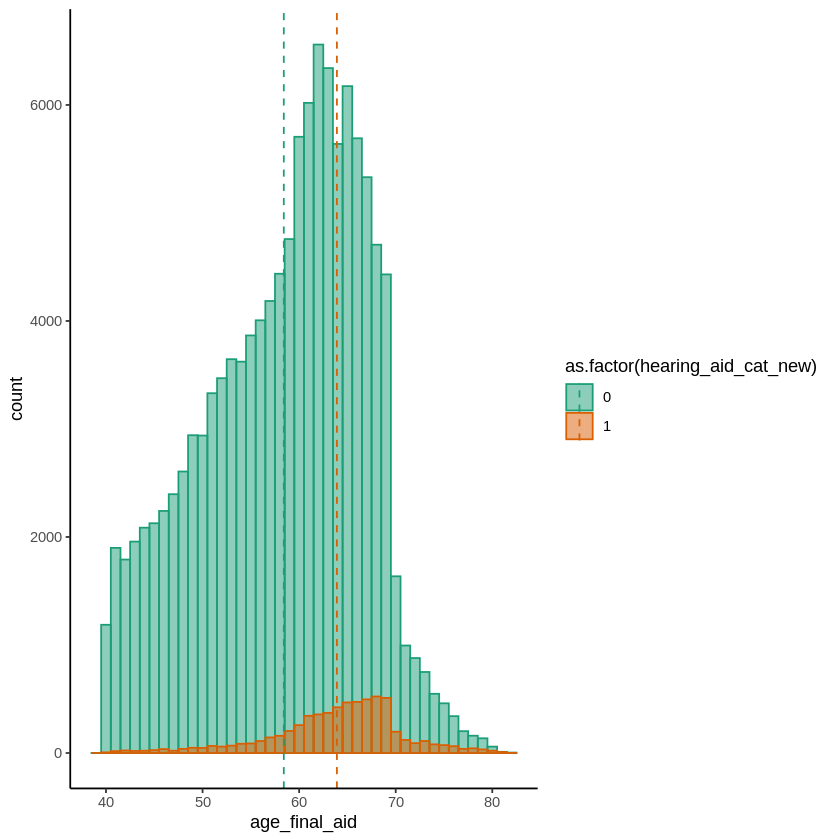

In [66]:
ggplot(f.3393_pheno, aes(x=age_final_aid, fill=as.factor(hearing_aid_cat_new), color=as.factor(hearing_aid_cat_new))) +
 geom_histogram(binwidth=1, alpha=0.5, position="identity")+
  scale_color_brewer(palette="Dark2")+
  scale_fill_brewer(palette="Dark2") +
  theme(legend.position="top") +
  geom_vline(data=mu, aes(xintercept=grp.mean, color=as.factor(hearing_aid_cat_new)),
             linetype="dashed") +
  theme_classic()

In [67]:
length(which((f.3393_pheno$hearing_aid_cat=="0" & f.3393_pheno$age_final_aid <50)))

[1] 21233

In [68]:
length(which((f.3393_pheno$hearing_aid_cat=="1" & f.3393_pheno$age_final_aid <50)))

[1] 256

In [69]:
mu1 <- ddply(f.3393_pheno, "sex", summarise, grp.mean=mean(age_final_aid))
head(mu1)

sex grp.mean
1 1   58.31905
2 0   59.09568

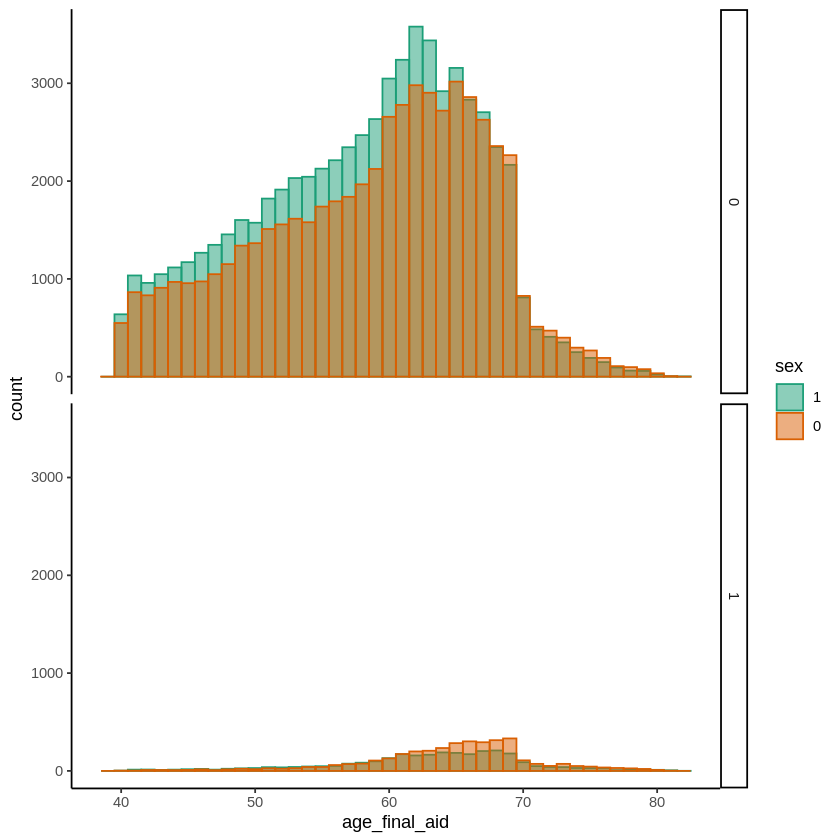

In [70]:
ggplot(f.3393_pheno, aes(x=age_final_aid, fill=sex, color=sex)) +
 geom_histogram(binwidth=1, alpha=0.5, position="identity")+
  scale_color_brewer(palette="Dark2")+
  scale_fill_brewer(palette="Dark2") +
  theme(legend.position="top") +
  theme_classic() +
  facet_grid(hearing_aid_cat_new ~ .)

## Find out controls positive for f.2247 & f.2257

In [71]:
control_check_3393 <- df_3393 %>%
    filter(hearing_aid_cat_new==0) %>%
    select(FID, IID, age_final_aid, sex, hearing_aid_cat_new, starts_with("f.2247"), starts_with("f.2257")) %>%
    mutate(remove_2247 = apply(select(.,starts_with("f.2247")), 1, function(x) length(which(x == "Yes")) > 0),
           remove_2257 = apply(select(.,starts_with("f.2257")), 1, function(x) length(which(x == "Yes")) > 0))
head(control_check_3393)
dim(control_check_3393)

FID     IID     age_final_aid sex hearing_aid_cat_new f.2247.0.0 f.2247.1.0
1 1000019 1000019 47            1   0                   Yes        NA        
2 1000035 1000035 63            0   0                   No         NA        
3 1000078 1000078 60            1   0                   No         No        
4 1000081 1000081 67            0   0                   No         NA        
5 1000198 1000198 41            1   0                   Yes        NA        
6 1000236 1000236 70            0   0                   No         NA        
  f.2247.2.0 f.2247.3.0 f.2257.0.0 f.2257.1.0 f.2257.2.0 f.2257.3.0 remove_2247
1 NA         NA         Yes        NA         NA         NA          TRUE      
2 NA         NA         Yes        NA         NA         NA         FALSE      
3 No         NA         No         No         No         NA         FALSE      
4 NA         NA         No         NA         NA         NA         FALSE      
5 NA         NA         Yes        NA         NA         NA          TRUE      
6 No         NA         No         NA         No         NA         FALSE      
  remove_2257
1  TRUE      
2  TRUE      
3 FALSE      
4 FALSE      
5  TRUE      
6 FALSE

[1] 122271     15

In [72]:
length(which(control_check_3393$remove_2247==TRUE)) #controls that replied yes to f.2247
length(which(control_check_3393$remove_2257==TRUE)) #controls that replied yes to f.2257
length(which(control_check_3393$remove_2247==TRUE & control_check_3393$remove_2257==TRUE)) # controls that replied yes to both
length(which(control_check_3393$remove_2247==TRUE | control_check_3393$remove_2257==TRUE)) # controls that replied yes to either

[1] 42065

[1] 64421

[1] 34691

[1] 71795

### Export files only white-British

In [44]:
write.table(f.3393_pheno, '200828_UKBB_Hearing_aid_f3393', quote = FALSE, row.names = FALSE)

### Export files expanded white

In [44]:
write.table(f.3393_pheno, '120120_UKBB_Hearing_aid_f3393_expandedwhite', quote = FALSE, row.names = FALSE)

In [92]:
write.table(f.3393_pheno, '041421_UKBB_Hearing_aid_f3393_expandedwhite_z974included', quote = FALSE, row.names = FALSE)

### Export files exome data

In [53]:
write.table(f.3393_pheno, 'phenotypes_exome_data/010421_UKBB_Hearing_aid_f3393_128254ind_exomes', quote = FALSE, row.names = FALSE)

## Hearing difficulty/problems (2247)
### step1: classify cases and controls

In [73]:
table(df.final.imp$f.2247.0.0)
dim(df.final.imp)


         Do not know I am completely deaf                   No 
                7629                   28               130324 
Prefer not to answer                  Yes 
                 129                44376 

[1] 182761   2267

In [74]:
# Recode function:
recode<-function(df,column_name){
  new_names<-c()
  for (i in column_name){
    new_column_name<-paste0(i,"_recode")
    new_names<-c(new_names,new_column_name)
    df[,new_column_name] <- revalue(df[,i], c("No"= 0, 
                                            "Yes" =1,
                                            "Prefer not to answer"= NA,
                                             "Do not know"=9,
                                             "I am completely deaf"=NA))
  }
  return (list(df=df,new_column_names=new_names))
}

# columns needs to be recoded:
column_name<-c("f.2247.0.0","f.2247.1.0","f.2247.2.0","f.2247.3.0")

# get a new data.frame with recoded columns added:
df.final.imp<-recode(df=df.final.imp,column_name)$df

# get names of recoded columns:
new_column_names<-recode(df=df.final.imp,column_name)$new_column_names

# show recode summary:
for (i in new_column_names)
{cat(i,"summary:");print(table(df.final.imp[,i]));cat("\n")}

The following `from` values were not present in `x`: Prefer not to answer, I am completely deaf

The following `from` values were not present in `x`: Prefer not to answer, I am completely deaf



f.2247.0.0_recode summary:
     9      0      1 
  7629 130324  44376 

f.2247.1.0_recode summary:
   9    0    1 
 520 6031 2903 

f.2247.2.0_recode summary:
    9     0     1 
 1281 14855  7897 

f.2247.3.0_recode summary:
  9   0   1 
 47 563 326 



## f.2247 Get possible answers

In [75]:
# Extract subset of data only with the recode columns of tinnitus
data_sub <- df.final.imp %>%
  select("IID",all_of(new_column_names)) 

# Function to extract all the available answers for 4 visits
# and put them in one string as "0000", "111", "991", etc

f2<-function(x){
  visit<-''
  for (i in 2:5){ # do not take the first column (i.e. IID)
    if (!is.na(x[i]))
    {visit<-paste0(visit,x[i])}
  }
  if(is.null(visit)){visit=NA}
  else{visit=visit}
  return (visit)
}

# Apply the above function and remove NAs
data_sub$visit<-apply(data_sub, 1, f2)

names(table(data_sub$visit))

[1] ""     "0"    "00"   "000"  "0000" "0001" "0009" "001"  "0010" "0011"
[11] "0019" "009"  "0090" "0091" "0099" "01"   "010"  "0100" "0101" "011" 
[21] "0111" "019"  "09"   "090"  "0900" "0901" "091"  "0910" "0911" "099" 
[31] "0991" "1"    "10"   "100"  "1000" "101"  "109"  "1090" "1099" "11"  
[41] "110"  "1101" "111"  "1111" "1119" "119"  "1190" "1191" "19"   "190" 
[51] "1900" "191"  "199"  "9"    "90"   "900"  "9000" "901"  "909"  "91"  
[61] "910"  "911"  "9110" "9111" "919"  "99"   "990"  "991"  "999"

In [76]:
table(data_sub$visit)
all_pattern<-unique(data_sub$visit)


            0     00    000   0000   0001   0009    001   0010   0011   0019 
   347 109838  12751   2932     77     10      6    339      3      7      1 
   009   0090   0091   0099     01    010   0100   0101    011   0111    019 
   110      3      1      1   2715    130      3      1    384      7     29 
    09    090   0900   0901    091   0910   0911    099   0991      1     10 
   822     95      1      2     50      1      1     49      1  37651    862 
   100   1000    101    109   1090   1099     11    110   1101    111   1111 
   117      1     78      8      1      1   4306     82      1    953     26 
  1119    119   1190   1191     19    190   1900    191    199      9     90 
     1     30      1      1    239     17      1     16     14   6565    344 
   900   9000    901    909     91    910    911   9110   9111    919     99 
    55      3     10     21    335      8     62      1      1      2    173 
   990    991    999 
    23     16     18 

## f.2247 Get all the consistent cases

In [77]:
all_no<-all_pattern[which(grepl("0",all_pattern) & !grepl("9",all_pattern) & !grepl("1",all_pattern))]
all_yes<-all_pattern[which(!grepl("0",all_pattern) & !grepl("9",all_pattern) & grepl("1",all_pattern))]
all_do_not_know<-all_pattern[which(!grepl("0",all_pattern) & grepl("9",all_pattern) & !grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%union(union(all_no,all_yes),all_do_not_know),"visit"])


     0     00    000   0000      1     11    111   1111      9     99    999 
109838  12751   2932     77  37651   4306    953     26   6565    173     18 

In [78]:
consistent_1<-c(all_no,all_yes,all_do_not_know)

# might be inconsistent cases:
do_not_know_no<-all_pattern[which(grepl("0",all_pattern) & grepl("9",all_pattern) & !grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%do_not_know_no,"visit"])


0009  009 0090 0099   09  090 0900  099   90  900 9000  909  990 
   6  110    3    1  822   95    1   49  344   55    3   21   23 

In [79]:
do_not_know_yes<-all_pattern[which(!grepl("0",all_pattern) & grepl("9",all_pattern) & grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%do_not_know_yes,"visit"])


1119  119 1191   19  191  199   91  911 9111  919  991 
   1   30    1  239   16   14  335   62    1    2   16 

In [80]:
yes_no<-all_pattern[which(grepl("0",all_pattern) & !grepl("9",all_pattern) & grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%yes_no,"visit"])


0001  001 0010 0011   01  010 0100 0101  011 0111   10  100 1000  101  110 1101 
  10  339    3    7 2715  130    3    1  384    7  862  117    1   78   82    1 

In [81]:
with_all_three<-all_pattern[which(grepl("0",all_pattern) & grepl("9",all_pattern) & grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%with_all_three,"visit"])


0019 0091  019 0901  091 0910 0911 0991  109 1090 1099 1190  190 1900  901  910 
   1    1   29    2   50    1    1    1    8    1    1    1   17    1   10    8 
9110 
   1 

In [82]:
might_inconsistent<-c(do_not_know_no,do_not_know_yes,yes_no,with_all_three)

## f.2247 Remove inconsistent cases

In [83]:
# get all the inconsistent cases:
exceptions<-c("91","911","9111","991","0001","001","0011","01","011","0111", "0091", "091","0911","0991","9001","901","9011")
inconsistent<-setdiff(might_inconsistent,exceptions)

cat("There are",length(which(is.empty(data_sub$visit))),"NAs, removed")

There are 347 NAs, removed

In [84]:
cat("There are",length(which(data_sub$visit%in%inconsistent)),"inconsistent cases, removed")

There are 3185 inconsistent cases, removed

In [85]:
# removed those NAs, consistent for do not know - 9 and inconsistent cases: 
IID_hearing_diff<-data_sub %>%
  filter(!is.empty(visit)) %>%
  filter((!visit%in%inconsistent)) %>%
  filter((!visit%in%all_do_not_know)) %>%
  select(IID)

dim(IID_hearing_diff)

[1] 172473      1

In [86]:
IID_hearing_diff<-IID_hearing_diff[,1]
cat("After removing all the NAs and inconsistent cases, there are",length(IID_hearing_diff),"cases left")

After removing all the NAs and inconsistent cases, there are 172473 cases left

In [87]:
# get the dataset after cleansing: 
df.hearing.diff<-df.final.imp %>%
  filter(IID%in%IID_hearing_diff)

dim(df.hearing.diff)

[1] 172473   2271

## f.2247 Step 1 classify cases and controls

In [88]:
hearing_diff <- df.hearing.diff %>% 
  select(IID,FID,f.22001.0.0, f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode)
head(hearing_diff)

IID     FID     f.22001.0.0 f.21003.0.0 f.21003.1.0 f.21003.2.0 f.21003.3.0
1 1000019 1000019 Female      47          NA          NA          NA         
2 1000035 1000035 Male        63          NA          NA          NA         
3 1000078 1000078 Female      52          57          60          NA         
4 1000081 1000081 Male        67          NA          NA          NA         
5 1000198 1000198 Female      41          NA          NA          NA         
6 1000224 1000224 Female      58          NA          NA          NA         
  f.2247.0.0_recode f.2247.1.0_recode f.2247.2.0_recode f.2247.3.0_recode
1 1                 NA                NA                NA               
2 0                 NA                NA                NA               
3 0                 0                 0                 NA               
4 0                 NA                NA                NA               
5 1                 NA                NA                NA               
6 0                 NA                NA                NA

In [89]:
data_sub <- select(hearing_diff,starts_with("f.2247"))

# Function to define cases
f<-function(x){
  visit<-c()
  for (i in 1:4){
    if (!is.na(x[i]))
    {visit<-c(visit,x[i])}
  }
  if ("1" %in% visit){result= TRUE}
  else{result=FALSE}
  return (result)
}

# Apply the above function
hearing_diff$cases<-apply(data_sub, 1, f)
head(hearing_diff,10)

IID     FID     f.22001.0.0 f.21003.0.0 f.21003.1.0 f.21003.2.0 f.21003.3.0
1  1000019 1000019 Female      47          NA          NA          NA         
2  1000035 1000035 Male        63          NA          NA          NA         
3  1000078 1000078 Female      52          57          60          NA         
4  1000081 1000081 Male        67          NA          NA          NA         
5  1000198 1000198 Female      41          NA          NA          NA         
6  1000224 1000224 Female      58          NA          NA          NA         
7  1000236 1000236 Male        61          NA          70          NA         
8  1000255 1000255 Female      51          NA          61          NA         
9  1000291 1000291 Male        62          NA          NA          NA         
10 1000304 1000304 Female      56          NA          NA          NA         
   f.2247.0.0_recode f.2247.1.0_recode f.2247.2.0_recode f.2247.3.0_recode
1  1                 NA                NA                NA               
2  0                 NA                NA                NA               
3  0                 0                 0                 NA               
4  0                 NA                NA                NA               
5  1                 NA                NA                NA               
6  0                 NA                NA                NA               
7  0                 NA                0                 NA               
8  0                 NA                0                 NA               
9  0                 NA                NA                NA               
10 0                 NA                NA                NA               
   cases
1   TRUE
2  FALSE
3  FALSE
4  FALSE
5   TRUE
6  FALSE
7  FALSE
8  FALSE
9  FALSE
10 FALSE

In [90]:
hearing_diff_cases <- hearing_diff %>% 
  filter(cases == TRUE)
head(hearing_diff_cases)
cat(dim(hearing_diff_cases)[1], "individuals are cases for f.2247")

IID     FID     f.22001.0.0 f.21003.0.0 f.21003.1.0 f.21003.2.0 f.21003.3.0
1 1000019 1000019 Female      47          NA          NA          NA         
2 1000198 1000198 Female      41          NA          NA          NA         
3 1000396 1000396 Male        48          NA          NA          NA         
4 1000494 1000494 Male        61          NA          NA          NA         
5 1001076 1001076 Male        69          NA          NA          NA         
6 1001123 1001123 Female      62          NA          NA          NA         
  f.2247.0.0_recode f.2247.1.0_recode f.2247.2.0_recode f.2247.3.0_recode cases
1 1                 NA                NA                NA                TRUE 
2 1                 NA                NA                NA                TRUE 
3 1                 NA                NA                NA                TRUE 
4 1                 NA                NA                NA                TRUE 
5 1                 NA                NA                NA                TRUE 
6 1                 NA                NA                NA                TRUE

46875 individuals are cases for f.2247

In [91]:
hearing_diff_controls <- hearing_diff %>% 
  filter(cases == FALSE)
head(hearing_diff_controls)
cat(dim(hearing_diff_controls)[1], "individuals are controls for f.2247")

IID     FID     f.22001.0.0 f.21003.0.0 f.21003.1.0 f.21003.2.0 f.21003.3.0
1 1000035 1000035 Male        63          NA          NA          NA         
2 1000078 1000078 Female      52          57          60          NA         
3 1000081 1000081 Male        67          NA          NA          NA         
4 1000224 1000224 Female      58          NA          NA          NA         
5 1000236 1000236 Male        61          NA          70          NA         
6 1000255 1000255 Female      51          NA          61          NA         
  f.2247.0.0_recode f.2247.1.0_recode f.2247.2.0_recode f.2247.3.0_recode cases
1 0                 NA                NA                NA                FALSE
2 0                 0                 0                 NA                FALSE
3 0                 NA                NA                NA                FALSE
4 0                 NA                NA                NA                FALSE
5 0                 NA                0                 NA                FALSE
6 0                 NA                0                 NA                FALSE

125598 individuals are controls for f.2247

In [92]:
dim(hearing_diff)[1]-nrow(hearing_diff_controls )- nrow(hearing_diff_cases)

[1] 0

## f.2247 Recode cases=1 and controls=0

In [93]:
hearing_diff$hearing_diff_cat <- as.integer(as.logical(hearing_diff$cases))
head(hearing_diff, 10)
# Get the number of NAs
length(which(is.na(hearing_diff$hearing_dif_cat)))

IID     FID     f.22001.0.0 f.21003.0.0 f.21003.1.0 f.21003.2.0 f.21003.3.0
1  1000019 1000019 Female      47          NA          NA          NA         
2  1000035 1000035 Male        63          NA          NA          NA         
3  1000078 1000078 Female      52          57          60          NA         
4  1000081 1000081 Male        67          NA          NA          NA         
5  1000198 1000198 Female      41          NA          NA          NA         
6  1000224 1000224 Female      58          NA          NA          NA         
7  1000236 1000236 Male        61          NA          70          NA         
8  1000255 1000255 Female      51          NA          61          NA         
9  1000291 1000291 Male        62          NA          NA          NA         
10 1000304 1000304 Female      56          NA          NA          NA         
   f.2247.0.0_recode f.2247.1.0_recode f.2247.2.0_recode f.2247.3.0_recode
1  1                 NA                NA                NA               
2  0                 NA                NA                NA               
3  0                 0                 0                 NA               
4  0                 NA                NA                NA               
5  1                 NA                NA                NA               
6  0                 NA                NA                NA               
7  0                 NA                0                 NA               
8  0                 NA                0                 NA               
9  0                 NA                NA                NA               
10 0                 NA                NA                NA               
   cases hearing_diff_cat
1   TRUE 1               
2  FALSE 0               
3  FALSE 0               
4  FALSE 0               
5   TRUE 1               
6  FALSE 0               
7  FALSE 0               
8  FALSE 0               
9  FALSE 0               
10 FALSE 0

[1] 0

## f.2247 Step 2: get the ages for hearing difficulty

In [94]:
# Get the subset data of cases
diff_age_cases = hearing_diff %>% 
  filter(hearing_diff_cat=="1")  %>%
  select(IID, f.2247.0.0_recode, f.2247.1.0_recode, f.2247.2.0_recode, f.2247.3.0_recode, f.21003.0.0, f.21003.1.0, f.21003.2.0, f.21003.3.0)
head(diff_age_cases,12)

IID     f.2247.0.0_recode f.2247.1.0_recode f.2247.2.0_recode
1  1000019 1                 NA                NA               
2  1000198 1                 NA                NA               
3  1000396 1                 NA                NA               
4  1000494 1                 NA                NA               
5  1001076 1                 NA                NA               
6  1001123 1                 NA                NA               
7  1001316 0                 NA                1                
8  1001373 1                 NA                NA               
9  1001384 1                 NA                NA               
10 1001577 1                 NA                NA               
11 1001636 1                 NA                NA               
12 1001775 1                 NA                NA               
   f.2247.3.0_recode f.21003.0.0 f.21003.1.0 f.21003.2.0 f.21003.3.0
1  NA                47          NA          NA          NA         
2  NA                41          NA          NA          NA         
3  NA                48          NA          NA          NA         
4  NA                61          NA          NA          NA         
5  NA                69          NA          NA          NA         
6  NA                62          NA          NA          NA         
7  NA                45          NA          51          NA         
8  NA                67          NA          NA          NA         
9  NA                61          NA          NA          NA         
10 NA                61          NA          NA          NA         
11 NA                64          NA          NA          NA         
12 NA                61          NA          NA          NA

In [95]:
# Get the # of column where first replied Yes:
diff_age_cases$visit_idx = apply(diff_age_cases, 1, function(x) unlist(which(x == '1')))
head(diff_age_cases)

IID     f.2247.0.0_recode f.2247.1.0_recode f.2247.2.0_recode
1 1000019 1                 NA                NA               
2 1000198 1                 NA                NA               
3 1000396 1                 NA                NA               
4 1000494 1                 NA                NA               
5 1001076 1                 NA                NA               
6 1001123 1                 NA                NA               
  f.2247.3.0_recode f.21003.0.0 f.21003.1.0 f.21003.2.0 f.21003.3.0 visit_idx
1 NA                47          NA          NA          NA          2        
2 NA                41          NA          NA          NA          2        
3 NA                48          NA          NA          NA          2        
4 NA                61          NA          NA          NA          2        
5 NA                69          NA          NA          NA          2        
6 NA                62          NA          NA          NA          2

In [96]:
# Define offset:
# offset: refers to the # of columns between the first age column (i.e.f.21003.0.0) and the first recode column (i.e.f.22247.0.0_recode)
offset = which(colnames(diff_age_cases) == 'f.21003.0.0') - which(colnames(diff_age_cases) == 'f.2247.0.0_recode')

# Define the function to extract the first time they said yes for cases 
f=get_age_func <- function(x) {
  visit_index=x[which(colnames(diff_age_cases)=="visit_idx")]
  index=min(unlist(visit_index))+offset
  age=x[index]
  final_age=unlist(age)
  if(is.null(final_age))
  {final_age<-NA}
  return(final_age)
}

# Get the final age for cases
diff_age_cases$age_final_diff = apply(diff_age_cases, 1, f)

# Show first 6 rows
head(diff_age_cases)
summary(diff_age_cases$age_final_diff)

IID     f.2247.0.0_recode f.2247.1.0_recode f.2247.2.0_recode
1 1000019 1                 NA                NA               
2 1000198 1                 NA                NA               
3 1000396 1                 NA                NA               
4 1000494 1                 NA                NA               
5 1001076 1                 NA                NA               
6 1001123 1                 NA                NA               
  f.2247.3.0_recode f.21003.0.0 f.21003.1.0 f.21003.2.0 f.21003.3.0 visit_idx
1 NA                47          NA          NA          NA          2        
2 NA                41          NA          NA          NA          2        
3 NA                48          NA          NA          NA          2        
4 NA                61          NA          NA          NA          2        
5 NA                69          NA          NA          NA          2        
6 NA                62          NA          NA          NA          2        
  age_final_diff
1 47            
2 41            
3 48            
4 61            
5 69            
6 62

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   39.0    54.0    61.0    59.4    65.0    81.0 

In [97]:
### Extract age for Control (2247)
diff_age_control <- hearing_diff %>% 
  filter(hearing_diff_cat == "0") %>%
  select(IID, f.2247.0.0_recode, f.2247.1.0_recode, f.2247.2.0_recode, f.2247.3.0_recode, f.21003.0.0, f.21003.1.0, f.21003.2.0, f.21003.3.0)
head(diff_age_control)

IID     f.2247.0.0_recode f.2247.1.0_recode f.2247.2.0_recode
1 1000035 0                 NA                NA               
2 1000078 0                 0                 0                
3 1000081 0                 NA                NA               
4 1000224 0                 NA                NA               
5 1000236 0                 NA                0                
6 1000255 0                 NA                0                
  f.2247.3.0_recode f.21003.0.0 f.21003.1.0 f.21003.2.0 f.21003.3.0
1 NA                63          NA          NA          NA         
2 NA                52          57          60          NA         
3 NA                67          NA          NA          NA         
4 NA                58          NA          NA          NA         
5 NA                61          NA          70          NA         
6 NA                51          NA          61          NA

In [98]:
# Get the # of column where last replied No:
diff_age_control$visit_idx = apply(diff_age_control, 1, function(x) unlist(which(x == '0')))

# Define offset:
# offset: refers to the # of columns between the first age column (i.e.f.21003.0.0) and the first recode column (i.e.f.3393.0.0_recode)
offset = which(colnames(diff_age_control) == 'f.21003.0.0') - which(colnames(diff_age_control) == 'f.2247.0.0_recode')

# Define the function to extract the last time they said no for control

f=get_age_func <- function(x) {
  visit_index=x[which(colnames(diff_age_control)=="visit_idx")]
  index=max(unlist(visit_index))+offset
  age=x[index]
  age=unlist(age)
  return(age)
}

# Get the final age for controls
diff_age_control$age_final_diff = apply(diff_age_control, 1, f)

# Show first 6 rows
head(diff_age_control)
summary(diff_age_control$age_final_diff)

IID     f.2247.0.0_recode f.2247.1.0_recode f.2247.2.0_recode
1 1000035 0                 NA                NA               
2 1000078 0                 0                 0                
3 1000081 0                 NA                NA               
4 1000224 0                 NA                NA               
5 1000236 0                 NA                0                
6 1000255 0                 NA                0                
  f.2247.3.0_recode f.21003.0.0 f.21003.1.0 f.21003.2.0 f.21003.3.0 visit_idx
1 NA                63          NA          NA          NA          2        
2 NA                52          57          60          NA          2, 3, 4  
3 NA                67          NA          NA          NA          2        
4 NA                58          NA          NA          NA          2        
5 NA                61          NA          70          NA          2, 4     
6 NA                51          NA          61          NA          2, 4     
  age_final_diff
1 63            
2 60            
3 67            
4 58            
5 70            
6 61

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  38.00   50.00   58.00   56.87   64.00   82.00 

In [99]:
# Merge age_cases and age_controls
hearing_diff_age <- rbind(diff_age_cases, diff_age_control) 
dim(hearing_diff_age)
head(hearing_diff_age)

[1] 172473     11

IID     f.2247.0.0_recode f.2247.1.0_recode f.2247.2.0_recode
1 1000019 1                 NA                NA               
2 1000198 1                 NA                NA               
3 1000396 1                 NA                NA               
4 1000494 1                 NA                NA               
5 1001076 1                 NA                NA               
6 1001123 1                 NA                NA               
  f.2247.3.0_recode f.21003.0.0 f.21003.1.0 f.21003.2.0 f.21003.3.0 visit_idx
1 NA                47          NA          NA          NA          2        
2 NA                41          NA          NA          NA          2        
3 NA                48          NA          NA          NA          2        
4 NA                61          NA          NA          NA          2        
5 NA                69          NA          NA          NA          2        
6 NA                62          NA          NA          NA          2        
  age_final_diff
1 47            
2 41            
3 48            
4 61            
5 69            
6 62

In [100]:
hearing_diff_age = merge(x = hearing_diff ,y = hearing_diff_age [,c("IID","age_final_diff")],by="IID", all.x=TRUE)
head(hearing_diff_age)
dim(hearing_diff_age)

IID     FID     f.22001.0.0 f.21003.0.0 f.21003.1.0 f.21003.2.0 f.21003.3.0
1 1000019 1000019 Female      47          NA          NA          NA         
2 1000035 1000035 Male        63          NA          NA          NA         
3 1000078 1000078 Female      52          57          60          NA         
4 1000081 1000081 Male        67          NA          NA          NA         
5 1000198 1000198 Female      41          NA          NA          NA         
6 1000224 1000224 Female      58          NA          NA          NA         
  f.2247.0.0_recode f.2247.1.0_recode f.2247.2.0_recode f.2247.3.0_recode cases
1 1                 NA                NA                NA                 TRUE
2 0                 NA                NA                NA                FALSE
3 0                 0                 0                 NA                FALSE
4 0                 NA                NA                NA                FALSE
5 1                 NA                NA                NA                 TRUE
6 0                 NA                NA                NA                FALSE
  hearing_diff_cat age_final_diff
1 1                47            
2 0                63            
3 0                60            
4 0                67            
5 1                41            
6 0                58

[1] 172473     14

## Merge dataset from f.3393 and f.2247

In [101]:
#Merge with complete database keep the all the rows from original db
df_3393_2247 = merge(x = df_3393, y = hearing_diff_age [,c("IID","hearing_diff_cat","age_final_diff")],by="IID", all.x=TRUE)
dim(df_3393_2247)
head(df_3393_2247)

[1] 182761   2271

IID     FID     ignore1 ignore2 ignore3 ignore4 f.31.0.0 f.34.0.0 f.53.0.0  
1 1000019 1000019 0       0       2       -9      Female   1960     2008-01-24
2 1000035 1000035 0       0       1       -9      Male     1944     2007-11-08
3 1000078 1000078 0       0       2       -9      Female   1955     2007-08-20
4 1000081 1000081 0       0       1       -9      Male     1942     2009-12-03
5 1000198 1000198 0       0       2       -9      Female   1967     2009-03-27
6 1000210 1000210 0       0       1       -9      Male     1941     2008-02-11
  f.53.1.0   ⋯ exclude sex f.3393.0.0_recode f.3393.1.0_recode
1 NA         ⋯ FALSE   1   0                 NA               
2 NA         ⋯ FALSE   0   0                 NA               
3 2012-11-01 ⋯ FALSE   1   NA                0                
4 NA         ⋯ FALSE   0   0                 NA               
5 NA         ⋯ FALSE   1   0                 NA               
6 NA         ⋯ FALSE   0   NA                NA               
  f.3393.2.0_recode f.3393.3.0_recode hearing_aid_cat_new age_final_aid
1 NA                NA                 0                  47           
2 NA                NA                 0                  63           
3 0                 NA                 0                  60           
4 NA                NA                 0                  67           
5 NA                NA                 0                  41           
6 NA                NA                NA                  NA           
  hearing_diff_cat age_final_diff
1  1               47            
2  0               63            
3  0               60            
4  0               67            
5  1               41            
6 NA               NA

## Reclassify individuals wearing hearing aid f.3393 but saying they don't have hearing difficulty f.2247

In [102]:
length(which(df_3393_2247$hearing_diff_cat == '0' & df_3393_2247$hearing_aid_cat_new == '1'))

[1] 65

In [103]:
#reclassify these 155 individulas as cases for 2247
df_3393_2247$hearing_diff_cat_new <- as.factor(df_3393_2247$hearing_diff_cat)
df_3393_2247$hearing_aid_cat_new <- as.factor(df_3393_2247$hearing_aid_cat)
#hearing_diff_new <- df_3393_2247 %>% 
 # mutate(hearing_diff_cat_new =ifelse(IID%in%inconsistent_aid_diff,1,hearing_diff_cat_new))
#head(hearing_diff_new)

In [104]:
246072 + 91057 # number of controls and cases

[1] 337129

In [105]:
#155 individuals state they have no hearing difficulty but they wear hearing aids
inconsistent_aid_diff <- df_3393_2247 %>%
    filter(hearing_diff_cat_new == '0' & hearing_aid_cat_new == '1') %>%
    select(IID)
nrow(inconsistent_aid_diff)
head(inconsistent_aid_diff)

[1] 65

IID    
1 1200917
2 1210033
3 1362299
4 1493176
5 1517018
6 1541460

In [106]:
inconsistent_aid_diff<-unlist(inconsistent_aid_diff[,1])
cat("There are",length(inconsistent_aid_diff),"individuals that state having no hearing difficulty but wear hearing aid")

There are 65 individuals that state having no hearing difficulty but wear hearing aid

In [107]:
df_3393_2247$hearing_diff_new <- df_3393_2247$hearing_diff_cat_new
df_3393_2247$hearing_diff_new[df_3393_2247$IID %in% inconsistent_aid_diff] <- "1"

In [108]:
#91057 individuals plus 155 that wear hearing aid 
check_merge <- df_3393_2247 %>% 
  select(hearing_diff_cat_new, hearing_aid_cat_new, hearing_diff_new) %>%
  filter(hearing_diff_new == "1" & hearing_aid_cat_new == "1" & hearing_diff_cat_new == "0" )
head(check_merge)
nrow(check_merge)

hearing_diff_cat_new hearing_aid_cat_new hearing_diff_new
1 0                    1                   1               
2 0                    1                   1               
3 0                    1                   1               
4 0                    1                   1               
5 0                    1                   1               
6 0                    1                   1

[1] 65

## f.2247 Verify the age for the new 155 cases

In [109]:
age_inconsistent <- df_3393_2247 %>%
    select(IID, age_final_aid, age_final_diff) %>%
    filter(IID %in% inconsistent_aid_diff)
head(age_inconsistent, 100)

IID     age_final_aid age_final_diff
1  1200917 70            70            
2  1210033 60            60            
3  1362299 45            45            
4  1493176 72            67            
5  1517018 62            62            
6  1541460 66            66            
7  1546451 57            57            
8  1648454 75            65            
9  1689328 72            64            
10 1751226 59            59            
11 1817231 49            49            
12 1851266 65            65            
13 1876770 64            64            
14 2005924 67            67            
15 2029410 70            64            
16 2077317 42            42            
17 2209847 53            53            
18 2266108 47            47            
19 2312984 69            61            
20 2402383 65            65            
21 2430352 52            52            
22 2568418 64            64            
23 2745960 65            65            
24 2877982 61            61            
25 2878413 41            41            
26 2908300 56            56            
27 3138286 76            69            
28 3145778 75            67            
29 3158613 44            44            
30 3180359 64            64            
⋮  ⋮       ⋮             ⋮             
36 3997300 65            65            
37 4060290 53            53            
38 4079946 41            41            
39 4093014 60            60            
40 4131470 55            55            
41 4200862 45            45            
42 4220414 44            44            
43 4403852 59            59            
44 4631605 51            51            
45 4672611 77            69            
46 4887642 66            66            
47 4899701 73            73            
48 4907912 42            42            
49 5007903 42            42            
50 5128506 67            59            
51 5132988 68            68            
52 5216241 73            63            
53 5282330 76            69            
54 5292807 49            49            
55 5324224 70            70            
56 5376281 69            69            
57 5472409 44            44            
58 5554820 69            69            
59 5618703 57            57            
60 5662470 52            52            
61 5740128 75            69            
62 5740764 72            66            
63 5827859 57            57            
64 5924018 52            52            
65 5999058 42            42

In [110]:
# There are inconsistencies in the age of the 155 new cases therefore I the age that should be used for them is the age_final_aid corresponding to the f.3393 diagnosis
all(age_inconsistent$age_final_aid == age_inconsistent$age_final_diff)

[1] FALSE

In [111]:
#Change the age to the one set inf f.3393 for the 155 individuals that are inconsistent
df_3393_2247 <- df_3393_2247 %>% 
  mutate(age_final_diff_new=ifelse((IID %in% age_inconsistent$IID & age_final_aid != age_final_diff),age_final_aid,age_final_diff))

## Export file for hearing difficulty f.2247

In [112]:
f.2247_pheno <- df_3393_2247 %>%
    filter(!(is.na(hearing_diff_new))) %>%
    select(FID, IID, age_final_diff_new, sex, hearing_diff_new)
head(f.2247_pheno)
dim(f.2247_pheno)

FID     IID     age_final_diff_new sex hearing_diff_new
1 1000019 1000019 47                 1   1               
2 1000035 1000035 63                 0   0               
3 1000078 1000078 60                 1   0               
4 1000081 1000081 67                 0   0               
5 1000198 1000198 41                 1   1               
6 1000224 1000224 58                 1   0

[1] 172473      5

In [113]:
nrow(f.2247_pheno %>% filter(hearing_diff_new == "0"))

[1] 125533

In [114]:
nrow(f.2247_pheno %>% filter(hearing_diff_new == "1"))

[1] 46940

## Histogram for age in f.2247

In [115]:
mu3 <- ddply(f.2247_pheno, "hearing_diff_new", summarise, grp.mean=mean(age_final_diff_new))
head(mu3)

hearing_diff_new grp.mean
1 0                56.87270
2 1                59.39844

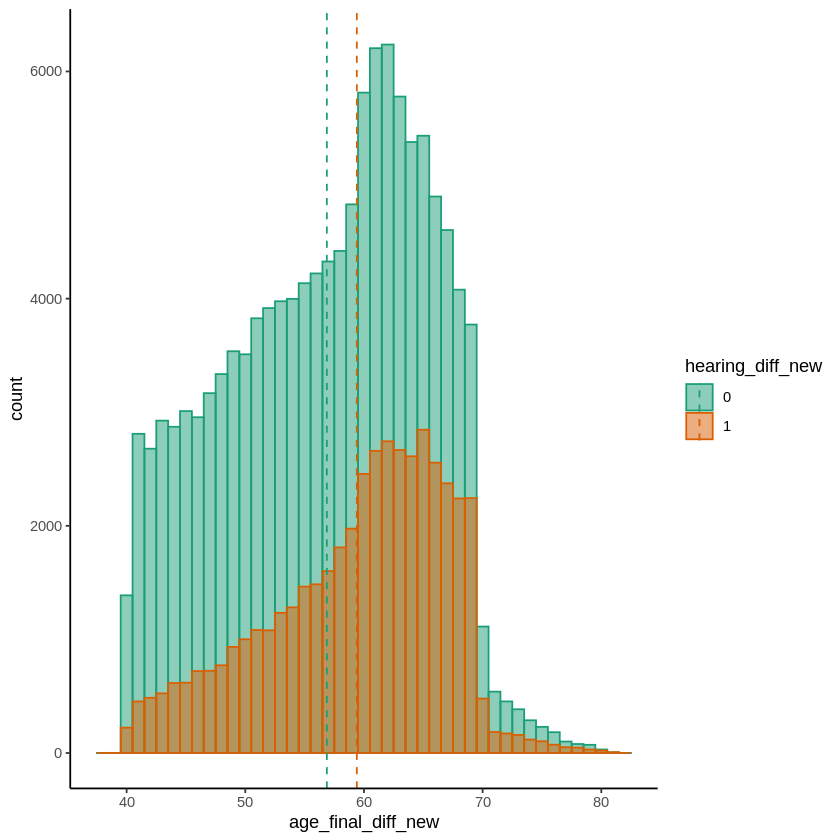

In [116]:
ggplot(f.2247_pheno, aes(x=age_final_diff_new, fill=hearing_diff_new, color=hearing_diff_new)) +
 geom_histogram(binwidth=1, alpha=0.5, position="identity")+
  scale_color_brewer(palette="Dark2")+
  scale_fill_brewer(palette="Dark2") +
  theme(legend.position="top") +
  geom_vline(data=mu3, aes(xintercept=grp.mean, color=hearing_diff_new),
             linetype="dashed") +
  theme_classic()

In [117]:
length(which((f.2247_pheno$hearing_diff_new=="0" & f.2247_pheno$age_final_diff <50)))
length(which((f.2247_pheno$hearing_diff_new=="1" & f.2247_pheno$age_final_diff <50)))

[1] 28684

[1] 6075

In [118]:
mu4 <- ddply(f.2247_pheno, "sex", summarise, grp.mean=mean(age_final_diff_new))
head(mu1)

sex grp.mean
1 1   58.31905
2 0   59.09568

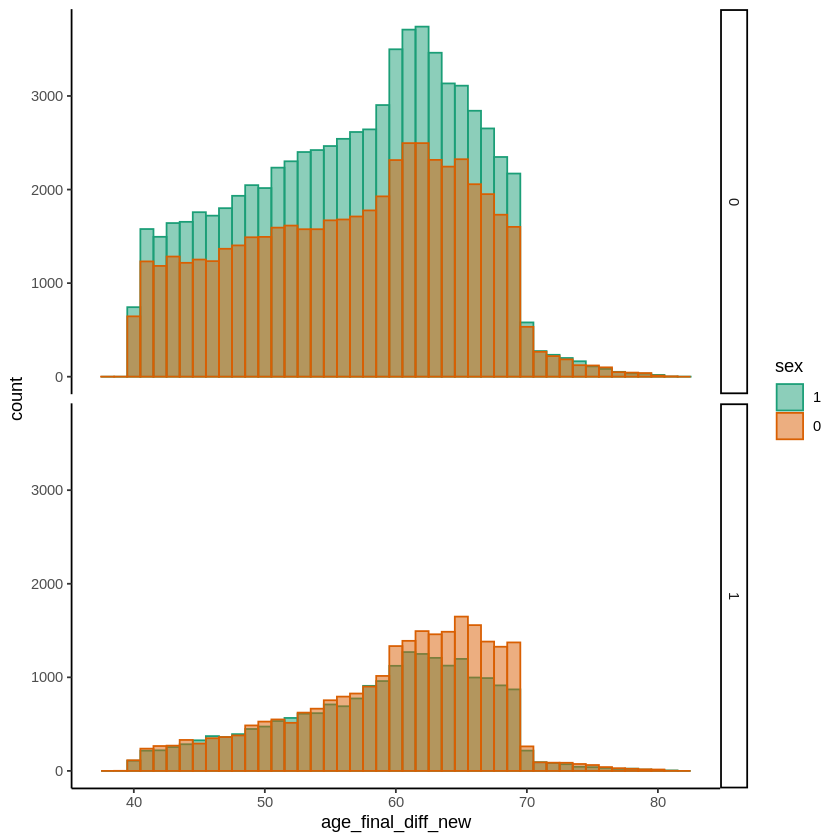

In [119]:
ggplot(f.2247_pheno, aes(x=age_final_diff_new, fill=sex, color=sex)) +
 geom_histogram(binwidth=1, alpha=0.5, position="identity")+
  scale_color_brewer(palette="Dark2")+
  scale_fill_brewer(palette="Dark2") +
  theme(legend.position="top") +
  theme_classic() +
  facet_grid(hearing_diff_new ~ .)

## Filter controls positive for f.3393 and/or f.2257

In [120]:
control_check_2247 <- df_3393_2247 %>%
    filter(hearing_diff_new==0) %>%
    select(FID, IID, age_final_diff_new, sex, hearing_diff_new, starts_with("f.2257"), starts_with("f.3393")) %>%
    mutate(remove_2257 = apply(select(.,starts_with("f.2257")), 1, function(x) length(which(x == "Yes")) > 0),
           remove_3393 = apply(select(.,starts_with("f.3393")), 1, function(x) length(which(x == "Yes")) > 0))
head(control_check_2247)

FID     IID     age_final_diff_new sex hearing_diff_new f.2257.0.0 f.2257.1.0
1 1000035 1000035 63                 0   0                Yes        NA        
2 1000078 1000078 60                 1   0                No         No        
3 1000081 1000081 67                 0   0                No         NA        
4 1000224 1000224 58                 1   0                No         NA        
5 1000236 1000236 70                 0   0                No         NA        
6 1000255 1000255 61                 1   0                No         NA        
  f.2257.2.0 f.2257.3.0 f.3393.0.0 f.3393.1.0 f.3393.2.0 f.3393.3.0
1 NA         NA         No         NA         NA         NA        
2 No         NA         NA         No         No         NA        
3 NA         NA         No         NA         NA         NA        
4 NA         NA         NA         NA         NA         NA        
5 No         NA         No         NA         No         NA        
6 No         NA         No         NA         No         NA        
  f.3393.0.0_recode f.3393.1.0_recode f.3393.2.0_recode f.3393.3.0_recode
1 0                 NA                NA                NA               
2 NA                0                 0                 NA               
3 0                 NA                NA                NA               
4 NA                NA                NA                NA               
5 0                 NA                0                 NA               
6 0                 NA                0                 NA               
  remove_2257 remove_3393
1  TRUE       FALSE      
2 FALSE       FALSE      
3 FALSE       FALSE      
4 FALSE       FALSE      
5 FALSE       FALSE      
6 FALSE       FALSE

In [121]:
length(which(control_check_2247$remove_2257==TRUE)) #controls that replied yes to f.2257
length(which(control_check_2247$remove_3393==TRUE)) #controls that replied yes to f.3393
length(which(control_check_2247$remove_2257==TRUE & control_check_2247$remove_3393==TRUE)) # controls that replied yes to both
length(which(control_check_2247$remove_2257==TRUE | control_check_2247$remove_3393==TRUE)) # controls that replied yes to either

[1] 25368

[1] 3

[1] 1

[1] 25370

### Export file white-British

In [93]:
write.table(f.2247_pheno, '200828_UKBB_Hearing_difficulty_f2247', quote = FALSE, row.names = FALSE)

### Export file white expanded

In [93]:
write.table(f.2247_pheno, '120120_UKBB_Hearing_difficulty_f2247_expandedwhite', quote = FALSE, row.names = FALSE)

### Export file exome data

In [276]:
length(which(is.na(f.2247_pheno$hearing_diff_new)))

[1] 0

In [101]:
write.table(f.2247_pheno, 'phenotypes_exome_data/010421_UKBB_Hearing_difficulty_f2247_171970ind_exomes', quote = FALSE, row.names = FALSE)

## f.2257 Hearing difficulty/background noise (2257)
### step1: classify cases and controls

In [122]:
table(df.final.imp$f.2257.0.0)
dim(df.final.imp)


         Do not know                   No Prefer not to answer 
                3644               112346                  160 
                 Yes 
               66379 

[1] 182761   2271

In [123]:
# Recode function:
recode<-function(df,column_name){
  new_names<-c()
  for (i in column_name){
    new_column_name<-paste0(i,"_recode")
    new_names<-c(new_names,new_column_name)
    df[,new_column_name] <- revalue(df[,i], c("No"= 0, 
                                            "Yes" =1,
                                            "Prefer not to answer"= NA,
                                             "Do not know"=9))
  }
  return (list(df=df,new_column_names=new_names))
}

# columns needs to be recoded:
column_name<-c("f.2257.0.0","f.2257.1.0","f.2257.2.0","f.2257.3.0")

# get a new data.frame with recoded columns added:
df.final.imp<-recode(df=df.final.imp,column_name)$df

# get names of recoded columns:
new_column_names<-recode(df=df.final.imp,column_name)$new_column_names

# show recode summary:
for (i in new_column_names)
{cat(i,"summary:");print(table(df.final.imp[,i]));cat("\n")}

The following `from` values were not present in `x`: Prefer not to answer

The following `from` values were not present in `x`: Prefer not to answer



f.2257.0.0_recode summary:
     9      0      1 
  3644 112346  66379 

f.2257.1.0_recode summary:
   9    0    1 
 205 5243 4008 

f.2257.2.0_recode summary:
    9     0     1 
  541 13021 10463 

f.2257.3.0_recode summary:
  9   0   1 
 26 504 406 



In [124]:
dim(df.final.imp)

[1] 182761   2275

## f.2257 Get patterns for all possible answers

In [125]:
# Extract subset of data only with the recode columns of tinnitus
data_sub <- df.final.imp %>%
  select("IID",all_of(new_column_names)) 

# Function to extract all the available answers for 4 visits
# and put them in one string as "0000", "111", "991", etc

f2<-function(x){
  visit<-''
  for (i in 2:5){ # do not take the first column (i.e. IID)
    if (!is.na(x[i]))
    {visit<-paste0(visit,x[i])}
  }
  if(is.null(visit)){visit=NA}
  else{visit=visit}
  return (visit)
}

# Apply the above function and remove NAs
data_sub$visit<-apply(data_sub, 1, f2)

names(table(data_sub$visit))

[1] ""     "0"    "00"   "000"  "0000" "0001" "0009" "001"  "0010" "0011"
[11] "009"  "0090" "01"   "010"  "0100" "0101" "011"  "0110" "0111" "019" 
[21] "09"   "090"  "0900" "091"  "099"  "1"    "10"   "100"  "1000" "1001"
[31] "101"  "1011" "109"  "1099" "11"   "110"  "1100" "1101" "111"  "1110"
[41] "1111" "1119" "119"  "19"   "190"  "1900" "191"  "199"  "9"    "90"  
[51] "900"  "9000" "901"  "909"  "91"   "910"  "911"  "9110" "919"  "99"  
[61] "990"  "991"  "999"  "9999"

In [126]:
table(data_sub$visit)
all_pattern<-unique(data_sub$visit)


          0    00   000  0000  0001  0009   001  0010  0011   009  0090    01 
  375 94910 10470  2411    62     6     2   360     6     6    43     1  3034 
  010  0100  0101   011  0110  0111   019    09   090  0900   091   099     1 
  212     2     2   386     1     8    16   340    42     2    23     5 55989 
   10   100  1000  1001   101  1011   109  1099    11   110  1100  1101   111 
 1507   234     4     1   150     3    12     1  6583   142     2     1  1534 
 1110  1111  1119   119    19   190  1900   191   199     9    90   900  9000 
    3    45     1    25   121     6     2    21     3  3135   183    27     1 
  901   909    91   910   911  9110   919    99   990   991   999  9999 
    7     3   178     9    21     1     5    53     7     7     7     2 

## f.2257 Get all the consitent cases

In [127]:
all_no<-all_pattern[which(grepl("0",all_pattern) & !grepl("9",all_pattern) & !grepl("1",all_pattern))]
all_yes<-all_pattern[which(!grepl("0",all_pattern) & !grepl("9",all_pattern) & grepl("1",all_pattern))]
all_do_not_know<-all_pattern[which(!grepl("0",all_pattern) & grepl("9",all_pattern) & !grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%union(union(all_no,all_yes),all_do_not_know),"visit"])


    0    00   000  0000     1    11   111  1111     9    99   999  9999 
94910 10470  2411    62 55989  6583  1534    45  3135    53     7     2 

In [128]:
consistent_1<-c(all_no,all_yes,all_do_not_know)

# might be inconsistent cases:
do_not_know_no<-all_pattern[which(grepl("0",all_pattern) & grepl("9",all_pattern) & !grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%do_not_know_no,"visit"])


0009  009 0090   09  090 0900  099   90  900 9000  909  990 
   2   43    1  340   42    2    5  183   27    1    3    7 

In [129]:
do_not_know_yes<-all_pattern[which(!grepl("0",all_pattern) & grepl("9",all_pattern) & grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%do_not_know_yes,"visit"])


1119  119   19  191  199   91  911  919  991 
   1   25  121   21    3  178   21    5    7 

In [130]:
yes_no<-all_pattern[which(grepl("0",all_pattern) & !grepl("9",all_pattern) & grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%yes_no,"visit"])


0001  001 0010 0011   01  010 0100 0101  011 0110 0111   10  100 1000 1001  101 
   6  360    6    6 3034  212    2    2  386    1    8 1507  234    4    1  150 
1011  110 1100 1101 1110 
   3  142    2    1    3 

In [131]:
with_all_three<-all_pattern[which(grepl("0",all_pattern) & grepl("9",all_pattern) & grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%with_all_three,"visit"])


 019  091  109 1099  190 1900  901  910 9110 
  16   23   12    1    6    2    7    9    1 

In [132]:
might_inconsistent<-c(do_not_know_no,do_not_know_yes,yes_no,with_all_three)

## f.2257 Remove all the inconsistent

In [133]:
# get all the inconsistent cases:
exceptions<-c("91","911","9111","991","9991","0001","001","0011","01","011","0111", "0091", "091","0911","9001","901","9011")
inconsistent<-setdiff(might_inconsistent,exceptions)

cat("There are",length(which(is.empty(data_sub$visit))),"NAs, removed")

There are 375 NAs, removed

In [134]:
cat("There are",length(which(data_sub$visit%in%inconsistent)),"inconsistent cases, removed")

There are 3149 inconsistent cases, removed

In [135]:
# removed those NAs, consistent for do not know - 9 and inconsistent cases: 
IID_hearing_noise<-data_sub %>%
  filter(!is.empty(visit)) %>%
  filter((!visit%in%inconsistent)) %>%
  filter((!visit%in%all_do_not_know)) %>%
  select(IID)

dim(IID_hearing_noise)

[1] 176040      1

In [136]:
IID_hearing_noise<-IID_hearing_noise[,1]
cat("After removing all the NAs and inconsistent cases, there are",length(IID_hearing_noise),"cases left")

After removing all the NAs and inconsistent cases, there are 176040 cases left

In [137]:
# get the dataset after cleansing: 
df.hearing.noise<-df.final.imp %>%
  filter(IID%in%IID_hearing_noise)

dim(df.hearing.noise)

[1] 176040   2275

## f.2257 Step 1 classify cases and controls

In [138]:
hearing_noise <- df.hearing.noise %>% 
  select(IID,FID,f.22001.0.0, f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode)
head(hearing_noise)

IID     FID     f.22001.0.0 f.21003.0.0 f.21003.1.0 f.21003.2.0 f.21003.3.0
1 1000019 1000019 Female      47          NA          NA          NA         
2 1000035 1000035 Male        63          NA          NA          NA         
3 1000078 1000078 Female      52          57          60          NA         
4 1000081 1000081 Male        67          NA          NA          NA         
5 1000198 1000198 Female      41          NA          NA          NA         
6 1000210 1000210 Male        66          NA          NA          NA         
  f.2257.0.0_recode f.2257.1.0_recode f.2257.2.0_recode f.2257.3.0_recode
1 1                 NA                NA                NA               
2 1                 NA                NA                NA               
3 0                 0                 0                 NA               
4 0                 NA                NA                NA               
5 1                 NA                NA                NA               
6 0                 NA                NA                NA

In [139]:
data_sub <- select(hearing_noise,starts_with("f.2257"))

# Function to define cases
f<-function(x){
  visit<-c()
  for (i in 1:4){
    if (!is.na(x[i]))
    {visit<-c(visit,x[i])}
  }
  if ("1" %in% visit){result= TRUE}
  else{result=FALSE}
  return (result)
}

# Apply the above function
hearing_noise$cases<-apply(data_sub, 1, f)
head(hearing_noise,10)

IID     FID     f.22001.0.0 f.21003.0.0 f.21003.1.0 f.21003.2.0 f.21003.3.0
1  1000019 1000019 Female      47          NA          NA          NA         
2  1000035 1000035 Male        63          NA          NA          NA         
3  1000078 1000078 Female      52          57          60          NA         
4  1000081 1000081 Male        67          NA          NA          NA         
5  1000198 1000198 Female      41          NA          NA          NA         
6  1000210 1000210 Male        66          NA          NA          NA         
7  1000224 1000224 Female      58          NA          NA          NA         
8  1000236 1000236 Male        61          NA          70          NA         
9  1000255 1000255 Female      51          NA          61          NA         
10 1000291 1000291 Male        62          NA          NA          NA         
   f.2257.0.0_recode f.2257.1.0_recode f.2257.2.0_recode f.2257.3.0_recode
1  1                 NA                NA                NA               
2  1                 NA                NA                NA               
3  0                 0                 0                 NA               
4  0                 NA                NA                NA               
5  1                 NA                NA                NA               
6  0                 NA                NA                NA               
7  0                 NA                NA                NA               
8  0                 NA                0                 NA               
9  0                 NA                0                 NA               
10 0                 NA                NA                NA               
   cases
1   TRUE
2   TRUE
3  FALSE
4  FALSE
5   TRUE
6  FALSE
7  FALSE
8  FALSE
9  FALSE
10 FALSE

In [140]:
hearing_noise_cases <- hearing_noise %>% 
  filter(cases == TRUE)
head(hearing_noise_cases)
cat(dim(hearing_noise_cases)[1], "individuals are cases for f.2257")

IID     FID     f.22001.0.0 f.21003.0.0 f.21003.1.0 f.21003.2.0 f.21003.3.0
1 1000019 1000019 Female      47          NA          NA          NA         
2 1000035 1000035 Male        63          NA          NA          NA         
3 1000198 1000198 Female      41          NA          NA          NA         
4 1000304 1000304 Female      56          NA          NA          NA         
5 1000396 1000396 Male        48          NA          NA          NA         
6 1000494 1000494 Male        61          NA          NA          NA         
  f.2257.0.0_recode f.2257.1.0_recode f.2257.2.0_recode f.2257.3.0_recode cases
1 1                 NA                NA                NA                TRUE 
2 1                 NA                NA                NA                TRUE 
3 1                 NA                NA                NA                TRUE 
4 1                 NA                NA                NA                TRUE 
5 1                 NA                NA                NA                TRUE 
6 1                 NA                NA                NA                TRUE

68187 individuals are cases for f.2257

In [141]:
hearing_noise_controls <- hearing_noise %>% 
  filter(cases == FALSE)
head(hearing_noise_controls)
cat(dim(hearing_noise_controls)[1], "individuals are controls for f.2257")

IID     FID     f.22001.0.0 f.21003.0.0 f.21003.1.0 f.21003.2.0 f.21003.3.0
1 1000078 1000078 Female      52          57          60          NA         
2 1000081 1000081 Male        67          NA          NA          NA         
3 1000210 1000210 Male        66          NA          NA          NA         
4 1000224 1000224 Female      58          NA          NA          NA         
5 1000236 1000236 Male        61          NA          70          NA         
6 1000255 1000255 Female      51          NA          61          NA         
  f.2257.0.0_recode f.2257.1.0_recode f.2257.2.0_recode f.2257.3.0_recode cases
1 0                 0                 0                 NA                FALSE
2 0                 NA                NA                NA                FALSE
3 0                 NA                NA                NA                FALSE
4 0                 NA                NA                NA                FALSE
5 0                 NA                0                 NA                FALSE
6 0                 NA                0                 NA                FALSE

107853 individuals are controls for f.2257

In [142]:
dim(hearing_noise)[1]-nrow(hearing_noise_cases) - nrow(hearing_noise_controls )

[1] 0

## f.2257 Recode cases=1 and controls=0

In [143]:
hearing_noise$hearing_noise_cat <- as.integer(as.logical(hearing_noise$cases))
head(hearing_noise, 10)
# Get the number of NAs
length(which(is.na(hearing_noise$hearing_noise_cat)))

IID     FID     f.22001.0.0 f.21003.0.0 f.21003.1.0 f.21003.2.0 f.21003.3.0
1  1000019 1000019 Female      47          NA          NA          NA         
2  1000035 1000035 Male        63          NA          NA          NA         
3  1000078 1000078 Female      52          57          60          NA         
4  1000081 1000081 Male        67          NA          NA          NA         
5  1000198 1000198 Female      41          NA          NA          NA         
6  1000210 1000210 Male        66          NA          NA          NA         
7  1000224 1000224 Female      58          NA          NA          NA         
8  1000236 1000236 Male        61          NA          70          NA         
9  1000255 1000255 Female      51          NA          61          NA         
10 1000291 1000291 Male        62          NA          NA          NA         
   f.2257.0.0_recode f.2257.1.0_recode f.2257.2.0_recode f.2257.3.0_recode
1  1                 NA                NA                NA               
2  1                 NA                NA                NA               
3  0                 0                 0                 NA               
4  0                 NA                NA                NA               
5  1                 NA                NA                NA               
6  0                 NA                NA                NA               
7  0                 NA                NA                NA               
8  0                 NA                0                 NA               
9  0                 NA                0                 NA               
10 0                 NA                NA                NA               
   cases hearing_noise_cat
1   TRUE 1                
2   TRUE 1                
3  FALSE 0                
4  FALSE 0                
5   TRUE 1                
6  FALSE 0                
7  FALSE 0                
8  FALSE 0                
9  FALSE 0                
10 FALSE 0

[1] 0

## f.2257 Step 2: get the ages for hearing difficulty with background noise

In [144]:
# Get the subset data of cases
noise_age_cases = hearing_noise %>% 
  filter(hearing_noise_cat=="1")  %>%
  select(IID, f.2257.0.0_recode, f.2257.1.0_recode, f.2257.2.0_recode, f.2257.3.0_recode, f.21003.0.0, f.21003.1.0, f.21003.2.0, f.21003.3.0)
head(noise_age_cases,12)

IID     f.2257.0.0_recode f.2257.1.0_recode f.2257.2.0_recode
1  1000019 1                 NA                NA               
2  1000035 1                 NA                NA               
3  1000198 1                 NA                NA               
4  1000304 1                 NA                NA               
5  1000396 1                 NA                NA               
6  1000494 1                 NA                NA               
7  1000551 1                 NA                NA               
8  1000817 1                 NA                NA               
9  1000875 1                 NA                NA               
10 1000988 1                 NA                NA               
11 1001076 1                 NA                NA               
12 1001080 1                 NA                NA               
   f.2257.3.0_recode f.21003.0.0 f.21003.1.0 f.21003.2.0 f.21003.3.0
1  NA                47          NA          NA          NA         
2  NA                63          NA          NA          NA         
3  NA                41          NA          NA          NA         
4  NA                56          NA          NA          NA         
5  NA                48          NA          NA          NA         
6  NA                61          NA          NA          NA         
7  NA                68          NA          NA          NA         
8  NA                58          NA          NA          NA         
9  NA                59          NA          NA          NA         
10 NA                65          NA          NA          NA         
11 NA                69          NA          NA          NA         
12 NA                62          NA          NA          NA

In [145]:
# Get the # of column where first replied Yes:
noise_age_cases$visit_idx = apply(noise_age_cases, 1, function(x) unlist(which(x == '1')))
head(noise_age_cases)

IID     f.2257.0.0_recode f.2257.1.0_recode f.2257.2.0_recode
1 1000019 1                 NA                NA               
2 1000035 1                 NA                NA               
3 1000198 1                 NA                NA               
4 1000304 1                 NA                NA               
5 1000396 1                 NA                NA               
6 1000494 1                 NA                NA               
  f.2257.3.0_recode f.21003.0.0 f.21003.1.0 f.21003.2.0 f.21003.3.0 visit_idx
1 NA                47          NA          NA          NA          2        
2 NA                63          NA          NA          NA          2        
3 NA                41          NA          NA          NA          2        
4 NA                56          NA          NA          NA          2        
5 NA                48          NA          NA          NA          2        
6 NA                61          NA          NA          NA          2

In [146]:
# Define offset:
# offset: refers to the # of columns between the first age column (i.e.f.21003.0.0) and the first recode column (i.e.f.2257.0.0_recode)
offset = which(colnames(noise_age_cases) == 'f.21003.0.0') - which(colnames(noise_age_cases) == 'f.2257.0.0_recode')

# Define the function to extract the first time they said yes for cases 
f=get_age_func <- function(x) {
  visit_index=x[which(colnames(noise_age_cases)=="visit_idx")]
  index=min(unlist(visit_index))+offset
  age=x[index]
  final_age=unlist(age)
  if(is.null(final_age))
  {final_age<-NA}
  return(final_age)
}

# Get the final age for cases
noise_age_cases$age_final_noise = apply(noise_age_cases, 1, f)

# Show first 6 rows
head(noise_age_cases)
summary(noise_age_cases$age_final_noise)

IID     f.2257.0.0_recode f.2257.1.0_recode f.2257.2.0_recode
1 1000019 1                 NA                NA               
2 1000035 1                 NA                NA               
3 1000198 1                 NA                NA               
4 1000304 1                 NA                NA               
5 1000396 1                 NA                NA               
6 1000494 1                 NA                NA               
  f.2257.3.0_recode f.21003.0.0 f.21003.1.0 f.21003.2.0 f.21003.3.0 visit_idx
1 NA                47          NA          NA          NA          2        
2 NA                63          NA          NA          NA          2        
3 NA                41          NA          NA          NA          2        
4 NA                56          NA          NA          NA          2        
5 NA                48          NA          NA          NA          2        
6 NA                61          NA          NA          NA          2        
  age_final_noise
1 47             
2 63             
3 41             
4 56             
5 48             
6 61

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  40.00   53.00   60.00   58.43   65.00   82.00 

In [147]:
### Extract age for Control (2257)
noise_age_control <- hearing_noise %>% 
  filter(hearing_noise_cat == "0") %>%
  select(IID, f.2257.0.0_recode, f.2257.1.0_recode, f.2257.2.0_recode, f.2257.3.0_recode, f.21003.0.0, f.21003.1.0, f.21003.2.0, f.21003.3.0)
head(noise_age_control)

IID     f.2257.0.0_recode f.2257.1.0_recode f.2257.2.0_recode
1 1000078 0                 0                 0                
2 1000081 0                 NA                NA               
3 1000210 0                 NA                NA               
4 1000224 0                 NA                NA               
5 1000236 0                 NA                0                
6 1000255 0                 NA                0                
  f.2257.3.0_recode f.21003.0.0 f.21003.1.0 f.21003.2.0 f.21003.3.0
1 NA                52          57          60          NA         
2 NA                67          NA          NA          NA         
3 NA                66          NA          NA          NA         
4 NA                58          NA          NA          NA         
5 NA                61          NA          70          NA         
6 NA                51          NA          61          NA

In [148]:
# Get the # of column where last replied No:
noise_age_control$visit_idx = apply(noise_age_control, 1, function(x) unlist(which(x == '0')))

# Define offset:
# offset: refers to the # of columns between the first age column (i.e.f.21003.0.0) and the first recode column (i.e.f.2257.0.0_recode)
offset = which(colnames(noise_age_control) == 'f.21003.0.0') - which(colnames(noise_age_control) == 'f.2257.0.0_recode')

# Define the function to extract the last time they said no for control

f=get_age_func <- function(x) {
  visit_index=x[which(colnames(noise_age_control)=="visit_idx")]
  index=max(unlist(visit_index))+offset
  age=x[index]
  age=unlist(age)
  return(age)
}

# Get the final age for controls
noise_age_control$age_final_noise = apply(noise_age_control, 1, f)

# Show first 6 rows
head(noise_age_control)
summary(noise_age_control$age_final_noise)

IID     f.2257.0.0_recode f.2257.1.0_recode f.2257.2.0_recode
1 1000078 0                 0                 0                
2 1000081 0                 NA                NA               
3 1000210 0                 NA                NA               
4 1000224 0                 NA                NA               
5 1000236 0                 NA                0                
6 1000255 0                 NA                0                
  f.2257.3.0_recode f.21003.0.0 f.21003.1.0 f.21003.2.0 f.21003.3.0 visit_idx
1 NA                52          57          60          NA          2, 3, 4  
2 NA                67          NA          NA          NA          2        
3 NA                66          NA          NA          NA          2        
4 NA                58          NA          NA          NA          2        
5 NA                61          NA          70          NA          2, 4     
6 NA                51          NA          61          NA          2, 4     
  age_final_noise
1 60             
2 67             
3 66             
4 58             
5 70             
6 61

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   38.0    50.0    58.0    56.8    63.0    82.0 

In [149]:
# Merge age_cases and age_controls
hearing_noise_age <- rbind(noise_age_cases, noise_age_control) 
dim(hearing_noise_age)
head(hearing_noise_age)

[1] 176040     11

IID     f.2257.0.0_recode f.2257.1.0_recode f.2257.2.0_recode
1 1000019 1                 NA                NA               
2 1000035 1                 NA                NA               
3 1000198 1                 NA                NA               
4 1000304 1                 NA                NA               
5 1000396 1                 NA                NA               
6 1000494 1                 NA                NA               
  f.2257.3.0_recode f.21003.0.0 f.21003.1.0 f.21003.2.0 f.21003.3.0 visit_idx
1 NA                47          NA          NA          NA          2        
2 NA                63          NA          NA          NA          2        
3 NA                41          NA          NA          NA          2        
4 NA                56          NA          NA          NA          2        
5 NA                48          NA          NA          NA          2        
6 NA                61          NA          NA          NA          2        
  age_final_noise
1 47             
2 63             
3 41             
4 56             
5 48             
6 61

In [150]:
hearing_noise_age = merge(x = hearing_noise ,y = hearing_noise_age [,c("IID","age_final_noise")],by="IID", all.x=TRUE)
head(hearing_noise_age)
dim(hearing_noise_age)

IID     FID     f.22001.0.0 f.21003.0.0 f.21003.1.0 f.21003.2.0 f.21003.3.0
1 1000019 1000019 Female      47          NA          NA          NA         
2 1000035 1000035 Male        63          NA          NA          NA         
3 1000078 1000078 Female      52          57          60          NA         
4 1000081 1000081 Male        67          NA          NA          NA         
5 1000198 1000198 Female      41          NA          NA          NA         
6 1000210 1000210 Male        66          NA          NA          NA         
  f.2257.0.0_recode f.2257.1.0_recode f.2257.2.0_recode f.2257.3.0_recode cases
1 1                 NA                NA                NA                 TRUE
2 1                 NA                NA                NA                 TRUE
3 0                 0                 0                 NA                FALSE
4 0                 NA                NA                NA                FALSE
5 1                 NA                NA                NA                 TRUE
6 0                 NA                NA                NA                FALSE
  hearing_noise_cat age_final_noise
1 1                 47             
2 1                 63             
3 0                 60             
4 0                 67             
5 1                 41             
6 0                 66

[1] 176040     14

## Merge f.3393, f.2247 and f.2257

In [151]:
#Merge with complete database keep the all the rows from original db
df_3393_2247_2257 = merge(x = df_3393_2247, y = hearing_noise_age [,c("IID","hearing_noise_cat","age_final_noise")],by="IID", all.x=TRUE)
dim(df_3393_2247_2257)
head(df_3393_2247_2257)

[1] 182761   2276

IID     FID     ignore1 ignore2 ignore3 ignore4 f.31.0.0 f.34.0.0 f.53.0.0  
1 1000019 1000019 0       0       2       -9      Female   1960     2008-01-24
2 1000035 1000035 0       0       1       -9      Male     1944     2007-11-08
3 1000078 1000078 0       0       2       -9      Female   1955     2007-08-20
4 1000081 1000081 0       0       1       -9      Male     1942     2009-12-03
5 1000198 1000198 0       0       2       -9      Female   1967     2009-03-27
6 1000210 1000210 0       0       1       -9      Male     1941     2008-02-11
  f.53.1.0   ⋯ f.3393.3.0_recode hearing_aid_cat_new age_final_aid
1 NA         ⋯ NA                0                   47           
2 NA         ⋯ NA                0                   63           
3 2012-11-01 ⋯ NA                0                   60           
4 NA         ⋯ NA                0                   67           
5 NA         ⋯ NA                0                   41           
6 NA         ⋯ NA                NA                  NA           
  hearing_diff_cat age_final_diff hearing_diff_cat_new hearing_diff_new
1  1               47             1                    1               
2  0               63             0                    0               
3  0               60             0                    0               
4  0               67             0                    0               
5  1               41             1                    1               
6 NA               NA             NA                   NA              
  age_final_diff_new hearing_noise_cat age_final_noise
1 47                 1                 47             
2 63                 1                 63             
3 60                 0                 60             
4 67                 0                 67             
5 41                 1                 41             
6 NA                 0                 66

## Export file for hearing with background noise f.2257

In [152]:
f.2257_pheno <- df_3393_2247_2257 %>%
    filter(!(is.na(hearing_noise_cat))) %>%
    select(FID, IID, age_final_noise, sex, hearing_noise_cat) 
    #mutate(hearing_noise_cat=recode_factor(hearing_noise_cat, `1`="case",`0`="control"),sex=recode_factor(sex, `1`="male", `0`="female" ))
head(f.2257_pheno)
dim(f.2257_pheno)

FID     IID     age_final_noise sex hearing_noise_cat
1 1000019 1000019 47              1   1                
2 1000035 1000035 63              0   1                
3 1000078 1000078 60              1   0                
4 1000081 1000081 67              0   0                
5 1000198 1000198 41              1   1                
6 1000210 1000210 66              0   0

[1] 176040      5

## Histogram for age of cases and controls

In [153]:
mu5 <- ddply(f.2257_pheno, "hearing_noise_cat", summarise, grp.mean=mean(age_final_noise))
head(mu)

hearing_aid_cat_new grp.mean
1 0                   58.41244
2 1                   63.91095

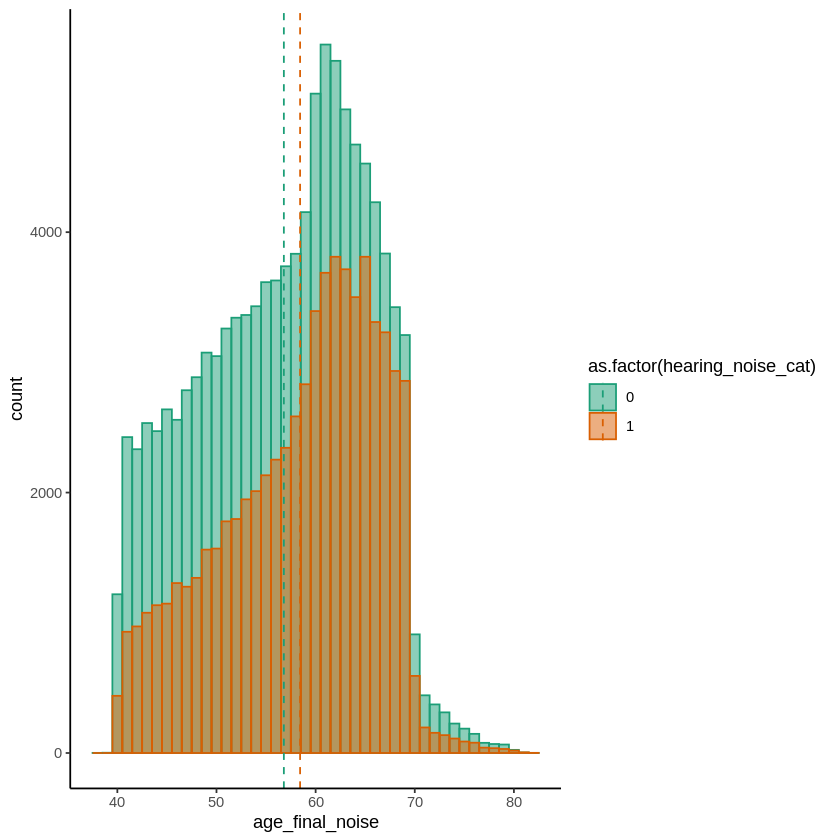

In [154]:
ggplot(f.2257_pheno, aes(x=age_final_noise, fill=as.factor(hearing_noise_cat), color=as.factor(hearing_noise_cat))) +
 geom_histogram(binwidth=1, alpha=0.5, position="identity")+
  scale_color_brewer(palette="Dark2")+
  scale_fill_brewer(palette="Dark2") +
  theme(legend.position="top") +
  geom_vline(data=mu5, aes(xintercept=grp.mean, color=as.factor(hearing_noise_cat)),
             linetype="dashed") +
  theme_classic()

In [155]:
length(which((f.2257_pheno$hearing_noise_cat=="0" & f.2257_pheno$age_final_noise <50)))

[1] 24932

In [156]:
length(which((f.2257_pheno$hearing_noise_cat=="1" & f.2257_pheno$age_final_noise <50)))

[1] 11190

In [157]:
mu6 <- ddply(f.2257_pheno, "sex", summarise, grp.mean=mean(age_final_noise))
head(mu6)

sex grp.mean
1 1   57.23873
2 0   57.66560

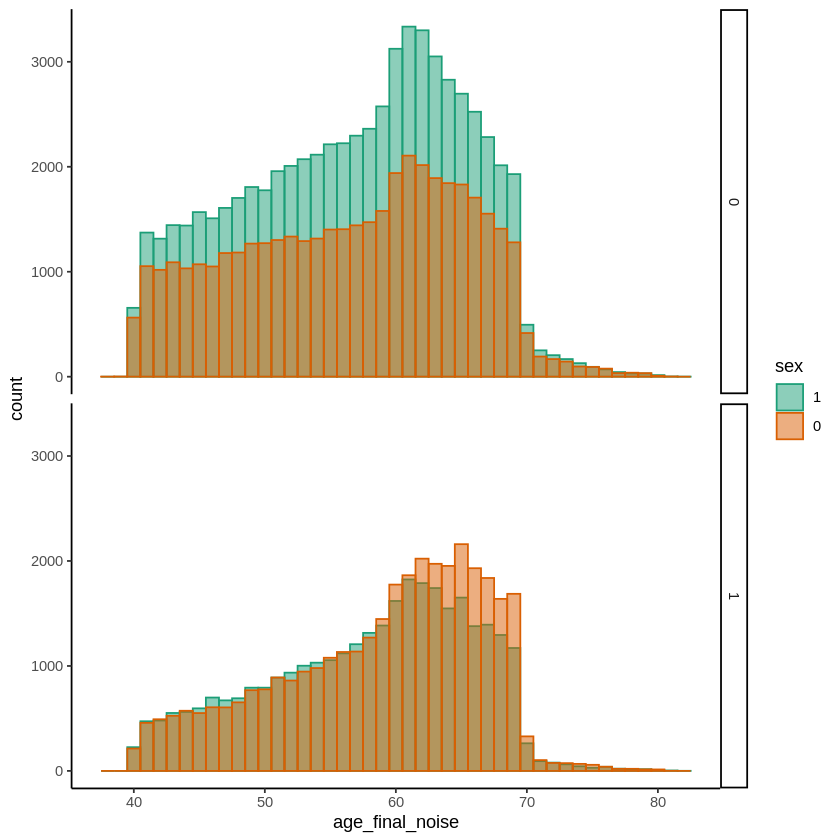

In [158]:
ggplot(f.2257_pheno, aes(x=age_final_noise, fill=sex, color=sex)) +
 geom_histogram(binwidth=1, alpha=0.5, position="identity")+
  scale_color_brewer(palette="Dark2")+
  scale_fill_brewer(palette="Dark2") +
  theme(legend.position="top") +
  theme_classic() +
  facet_grid(hearing_noise_cat ~ .)

## Find out controls positive for f.2247 & f.3393

In [159]:
control_check_2257 <- df_3393_2247_2257 %>%
    filter(hearing_noise_cat==0) %>%
    select(FID, IID, age_final_noise, sex, hearing_noise_cat, starts_with("f.2247"), starts_with("f.3393")) %>%
    mutate(remove_2247 = apply(select(.,starts_with("f.2247")), 1, function(x) length(which(x == "Yes")) > 0),
           remove_3393 = apply(select(.,starts_with("f.3393")), 1, function(x) length(which(x == "Yes")) > 0))
head(control_check_2257)

FID     IID     age_final_noise sex hearing_noise_cat f.2247.0.0  f.2247.1.0
1 1000078 1000078 60              1   0                 No          No        
2 1000081 1000081 67              0   0                 No          NA        
3 1000210 1000210 66              0   0                 Do not know NA        
4 1000224 1000224 58              1   0                 No          NA        
5 1000236 1000236 70              0   0                 No          NA        
6 1000255 1000255 61              1   0                 No          NA        
  f.2247.2.0 f.2247.3.0 f.3393.0.0 f.3393.1.0 f.3393.2.0 f.3393.3.0
1 No         NA         NA         No         No         NA        
2 NA         NA         No         NA         NA         NA        
3 NA         NA         NA         NA         NA         NA        
4 NA         NA         NA         NA         NA         NA        
5 No         NA         No         NA         No         NA        
6 No         NA         No         NA         No         NA        
  f.3393.0.0_recode f.3393.1.0_recode f.3393.2.0_recode f.3393.3.0_recode
1 NA                0                 0                 NA               
2 0                 NA                NA                NA               
3 NA                NA                NA                NA               
4 NA                NA                NA                NA               
5 0                 NA                0                 NA               
6 0                 NA                0                 NA               
  remove_2247 remove_3393
1 FALSE       FALSE      
2 FALSE       FALSE      
3 FALSE       FALSE      
4 FALSE       FALSE      
5 FALSE       FALSE      
6 FALSE       FALSE

In [160]:
length(which(control_check_2257$remove_2247==TRUE)) #controls that replied yes to f.2247
length(which(control_check_2257$remove_3393==TRUE)) #controls that replied yes to f.3393
length(which(control_check_2257$remove_2247==TRUE & control_check_2257$remove_3393==TRUE)) # controls that replied yes to both
length(which(control_check_2257$remove_2247==TRUE | control_check_2257$remove_3393==TRUE)) # controls that replied yes to either

[1] 7040

[1] 239

[1] 209

[1] 7070

### Export files white-British

In [133]:
write.table(f.2257_pheno, '200828_UKBB_Hearing_background_noise_f2257', quote = FALSE, row.names = FALSE)

### Export files white expanded

In [133]:
write.table(f.2257_pheno, '120120_UKBB_Hearing_background_noise_f2257_expandedwhite', quote = FALSE, row.names = FALSE)

### Export files exome data

In [142]:
write.table(f.2257_pheno, 'phenotypes_exome_data/010421_UKBB_Hearing_background_noise_f2257_175531ind_exomes', quote = FALSE, row.names = FALSE)

## Combined phenotype f.2247 and f.2257

In [161]:
hybrid_inconsistent <- df_3393_2247_2257 %>%
 filter(hearing_noise_cat != hearing_diff_new)
head(hybrid_inconsistent)
cat ("There are ",nrow(hybrid_inconsistent),"individuals inconsistent for f.2247 and f.2257")
dim(df_3393_2247_2257)

IID     FID     ignore1 ignore2 ignore3 ignore4 f.31.0.0 f.34.0.0 f.53.0.0  
1 1000035 1000035 0       0       1       -9      Male     1944     2007-11-08
2 1000304 1000304 0       0       2       -9      Female   1951     2008-02-15
3 1000817 1000817 0       0       1       -9      Male     1950     2009-04-18
4 1000988 1000988 0       0       2       -9      Female   1942     2008-04-10
5 1001080 1001080 0       0       2       -9      Female   1947     2010-04-30
6 1001316 1001316 0       0       1       -9      Male     1964     2010-04-08
  f.53.1.0 ⋯ f.3393.3.0_recode hearing_aid_cat_new age_final_aid
1 NA       ⋯ NA                0                   63           
2 NA       ⋯ NA                0                   56           
3 NA       ⋯ NA                0                   58           
4 NA       ⋯ NA                0                   65           
5 NA       ⋯ NA                0                   62           
6 NA       ⋯ NA                0                   51           
  hearing_diff_cat age_final_diff hearing_diff_cat_new hearing_diff_new
1 0                63             0                    0               
2 0                56             0                    0               
3 0                58             0                    0               
4 0                65             0                    0               
5 0                62             0                    0               
6 1                51             1                    1               
  age_final_diff_new hearing_noise_cat age_final_noise
1 63                 1                 63             
2 56                 1                 56             
3 58                 1                 58             
4 65                 1                 65             
5 62                 1                 62             
6 51                 0                 51

There are  30702 individuals inconsistent for f.2247 and f.2257

[1] 182761   2276

In [178]:
length(which(!is.na(df_3393_2247_2257$hearing_noise_cat) & !is.na(df_3393_2247_2257$hearing_diff_new)))

[1] 167947

In [163]:
length(which(is.na(df_3393_2247_2257$hearing_noise_cat) | is.na(df_3393_2247_2257$hearing_diff_new))) 

[1] 14814

In [168]:
hybrid_consistent <- df_3393_2247_2257 %>%
 filter(hearing_noise_cat == hearing_diff_new)
head(hybrid_consistent)
cat ("There are ",nrow(hybrid_consistent),"individuals consistent for f.2247 and f.2257")

IID     FID     ignore1 ignore2 ignore3 ignore4 f.31.0.0 f.34.0.0 f.53.0.0  
1 1000019 1000019 0       0       2       -9      Female   1960     2008-01-24
2 1000078 1000078 0       0       2       -9      Female   1955     2007-08-20
3 1000081 1000081 0       0       1       -9      Male     1942     2009-12-03
4 1000198 1000198 0       0       2       -9      Female   1967     2009-03-27
5 1000224 1000224 0       0       2       -9      Female   1951     2009-05-01
6 1000236 1000236 0       0       1       -9      Male     1948     2010-01-30
  f.53.1.0   ⋯ f.3393.3.0_recode hearing_aid_cat_new age_final_aid
1 NA         ⋯ NA                0                   47           
2 2012-11-01 ⋯ NA                0                   60           
3 NA         ⋯ NA                0                   67           
4 NA         ⋯ NA                0                   41           
5 NA         ⋯ NA                NA                  NA           
6 NA         ⋯ NA                0                   70           
  hearing_diff_cat age_final_diff hearing_diff_cat_new hearing_diff_new
1 1                47             1                    1               
2 0                60             0                    0               
3 0                67             0                    0               
4 1                41             1                    1               
5 0                58             0                    0               
6 0                70             0                    0               
  age_final_diff_new hearing_noise_cat age_final_noise
1 47                 1                 47             
2 60                 0                 60             
3 67                 0                 67             
4 41                 1                 41             
5 58                 0                 58             
6 70                 0                 70

There are  137245 individuals consistent for f.2247 and f.2257

In [169]:
age_consistency <- hybrid_consistent %>%
    select(IID, age_final_diff, age_final_noise)
head(age_consistency)

IID     age_final_diff age_final_noise
1 1000019 47             47             
2 1000078 60             60             
3 1000081 67             67             
4 1000198 41             41             
5 1000224 58             58             
6 1000236 70             70

In [170]:
# There are inconsistencies for the age between hearing difficulty and background noise
all(age_consistency$age_final_diff == age_consistency$age_final_noise)

[1] FALSE

In [171]:
age_inconsistency <- hybrid_consistent %>%
    filter(age_final_diff != age_final_noise)
head(age_inconsistency)
cat ("There are",nrow(age_inconsistency), "individuals with inconsistent ages for hearing difficulty and background noise")

IID     FID     ignore1 ignore2 ignore3 ignore4 f.31.0.0 f.34.0.0 f.53.0.0  
1 1006407 1006407 0       0       2       -9      Female   1949     2008-09-30
2 1006513 1006513 0       0       2       -9      Female   1955     2010-02-23
3 1012730 1012730 0       0       1       -9      Male     1947     2010-05-26
4 1015865 1015865 0       0       2       -9      Female   1948     2010-04-27
5 1016086 1016086 0       0       1       -9      Male     1948     2008-08-20
6 1017495 1017495 0       0       1       -9      Male     1957     2008-08-04
  f.53.1.0 ⋯ f.3393.3.0_recode hearing_aid_cat_new age_final_aid
1 NA       ⋯ NA                0                   65           
2 NA       ⋯ NA                1                   59           
3 NA       ⋯ 0                 0                   73           
4 NA       ⋯ NA                0                   71           
5 NA       ⋯ NA                0                   70           
6 NA       ⋯ NA                0                   58           
  hearing_diff_cat age_final_diff hearing_diff_cat_new hearing_diff_new
1 1                59             1                    1               
2 1                59             1                    1               
3 1                70             1                    1               
4 1                71             1                    1               
5 1                60             1                    1               
6 1                58             1                    1               
  age_final_diff_new hearing_noise_cat age_final_noise
1 59                 1                 65             
2 59                 1                 54             
3 70                 1                 63             
4 71                 1                 62             
5 60                 1                 70             
6 58                 1                 51

There are 1918 individuals with inconsistent ages for hearing difficulty and background noise

In [179]:
age_inconsistency_cases <- hybrid_consistent %>%
    filter(hearing_noise_cat == 1 &  hearing_diff_new ==1) %>%
    filter(age_final_diff != age_final_noise) %>%
    select(FID, IID, sex, hearing_diff_new, hearing_noise_cat, age_final_diff, age_final_noise)
head(age_inconsistency_cases)
cat ("There are",nrow(age_inconsistency_cases), "cases with inconsistent ages for hearing difficulty and background noise")

FID     IID     sex hearing_diff_new hearing_noise_cat age_final_diff
1 1006407 1006407 1   1                1                 59            
2 1006513 1006513 1   1                1                 59            
3 1012730 1012730 0   1                1                 70            
4 1015865 1015865 1   1                1                 71            
5 1016086 1016086 0   1                1                 60            
6 1017495 1017495 0   1                1                 58            
  age_final_noise
1 65             
2 54             
3 63             
4 62             
5 70             
6 51

There are 1916 cases with inconsistent ages for hearing difficulty and background noise

In [180]:
age_inconsistency_controls <- hybrid_consistent %>%
    filter(hearing_noise_cat == 0 &  hearing_diff_new == 0) %>%
    filter(age_final_diff != age_final_noise) %>%
    select(FID, IID, sex, hearing_diff_new, hearing_noise_cat, age_final_diff, age_final_noise)
head(age_inconsistency_controls)
cat ("There are",nrow(age_inconsistency_controls), "controls with inconsistent ages for hearing difficulty and background noise")

FID     IID     sex hearing_diff_new hearing_noise_cat age_final_diff
1 1740024 1740024 0   0                0                 41            
2 5668953 5668953 1   0                0                 74            
  age_final_noise
1 46             
2 69

There are 2 controls with inconsistent ages for hearing difficulty and background noise

In [181]:
#get the minimum age for 2247 and 2257 for cases
age_inconsistency_cases <- transform(age_inconsistency_cases, age_diff_noise = pmin(age_final_noise, age_final_diff))
head(age_inconsistency_cases)

FID     IID     sex hearing_diff_new hearing_noise_cat age_final_diff
1 1006407 1006407 1   1                1                 59            
2 1006513 1006513 1   1                1                 59            
3 1012730 1012730 0   1                1                 70            
4 1015865 1015865 1   1                1                 71            
5 1016086 1016086 0   1                1                 60            
6 1017495 1017495 0   1                1                 58            
  age_final_noise age_diff_noise
1 65              59            
2 54              54            
3 63              63            
4 62              62            
5 70              60            
6 51              51

In [182]:
#get the maximun age for 2247 and 2257 for controls
age_inconsistency_controls <- transform(age_inconsistency_controls, age_diff_noise = pmax(age_final_noise, age_final_diff))
head(age_inconsistency_controls,10)

FID     IID     sex hearing_diff_new hearing_noise_cat age_final_diff
1 1740024 1740024 0   0                0                 41            
2 5668953 5668953 1   0                0                 74            
  age_final_noise age_diff_noise
1 46              46            
2 69              74

In [183]:
age_solved <- rbind(age_inconsistency_cases, age_inconsistency_controls)
nrow(age_solved)
head(age_solved)

[1] 1918

FID     IID     sex hearing_diff_new hearing_noise_cat age_final_diff
1 1006407 1006407 1   1                1                 59            
2 1006513 1006513 1   1                1                 59            
3 1012730 1012730 0   1                1                 70            
4 1015865 1015865 1   1                1                 71            
5 1016086 1016086 0   1                1                 60            
6 1017495 1017495 0   1                1                 58            
  age_final_noise age_diff_noise
1 65              59            
2 54              54            
3 63              63            
4 62              62            
5 70              60            
6 51              51

In [184]:
hybrid_age_consistent <- hybrid_consistent  %>%
    filter(age_final_diff == age_final_noise) %>%
    select(FID, IID, sex, hearing_diff_new, hearing_noise_cat, age_final_diff, age_final_noise) %>%
    mutate(age_diff_noise = age_final_diff) 
head(hybrid_age_consistent)
cat ("There are ",nrow(hybrid_age_consistent),"individuals consistent for age and phenotype for f.2247 and f.2257")

FID     IID     sex hearing_diff_new hearing_noise_cat age_final_diff
1 1000019 1000019 1   1                1                 47            
2 1000078 1000078 1   0                0                 60            
3 1000081 1000081 0   0                0                 67            
4 1000198 1000198 1   1                1                 41            
5 1000224 1000224 1   0                0                 58            
6 1000236 1000236 0   0                0                 70            
  age_final_noise age_diff_noise
1 47              47            
2 60              60            
3 67              67            
4 41              41            
5 58              58            
6 70              70

There are  135327 individuals consistent for age and phenotype for f.2247 and f.2257

In [185]:
f2247_f2257_pheno <- rbind (hybrid_age_consistent, age_solved)
head(f2247_f2257_pheno)
nrow(f2247_f2257_pheno)

FID     IID     sex hearing_diff_new hearing_noise_cat age_final_diff
1 1000019 1000019 1   1                1                 47            
2 1000078 1000078 1   0                0                 60            
3 1000081 1000081 0   0                0                 67            
4 1000198 1000198 1   1                1                 41            
5 1000224 1000224 1   0                0                 58            
6 1000236 1000236 0   0                0                 70            
  age_final_noise age_diff_noise
1 47              47            
2 60              60            
3 67              67            
4 41              41            
5 58              58            
6 70              70

[1] 137245

In [186]:
names(f2247_f2257_pheno)[names(f2247_f2257_pheno) == 'hearing_diff_new'] <- 'f2247_f2257'
names(f2247_f2257_pheno)[names(f2247_f2257_pheno) == 'age_diff_noise'] <- 'age_combined'
f2247_f2257_pheno <- f2247_f2257_pheno %>%
 select(FID, IID, age_combined, sex, f2247_f2257 )
head(f2247_f2257_pheno)

FID     IID     age_combined sex f2247_f2257
1 1000019 1000019 47           1   1          
2 1000078 1000078 60           1   0          
3 1000081 1000081 67           0   0          
4 1000198 1000198 41           1   1          
5 1000224 1000224 58           1   0          
6 1000236 1000236 70           0   0

In [187]:
cases_combined <- f2247_f2257_pheno %>%
    filter(f2247_f2257 == 1)
nrow(cases_combined)

[1] 39233

In [188]:
controls_combined <- f2247_f2257_pheno %>%
    filter(f2247_f2257 == 0)
nrow(controls_combined)

[1] 98012

## Merge with complete database

In [190]:
#Merge with complete database keep the all the rows from original db
df_3393_2247_2257_combined = merge(x = df_3393_2247_2257, y = f2247_f2257_pheno [,c("IID","f2247_f2257","age_combined")],by="IID", all.x=TRUE)
dim(df_3393_2247_2257_combined)
head(df_3393_2247_2257_combined)

[1] 182761   2278

IID     FID     ignore1 ignore2 ignore3 ignore4 f.31.0.0 f.34.0.0 f.53.0.0  
1 1000019 1000019 0       0       2       -9      Female   1960     2008-01-24
2 1000035 1000035 0       0       1       -9      Male     1944     2007-11-08
3 1000078 1000078 0       0       2       -9      Female   1955     2007-08-20
4 1000081 1000081 0       0       1       -9      Male     1942     2009-12-03
5 1000198 1000198 0       0       2       -9      Female   1967     2009-03-27
6 1000210 1000210 0       0       1       -9      Male     1941     2008-02-11
  f.53.1.0   ⋯ age_final_aid hearing_diff_cat age_final_diff
1 NA         ⋯ 47             1               47            
2 NA         ⋯ 63             0               63            
3 2012-11-01 ⋯ 60             0               60            
4 NA         ⋯ 67             0               67            
5 NA         ⋯ 41             1               41            
6 NA         ⋯ NA            NA               NA            
  hearing_diff_cat_new hearing_diff_new age_final_diff_new hearing_noise_cat
1 1                    1                47                 1                
2 0                    0                63                 1                
3 0                    0                60                 0                
4 0                    0                67                 0                
5 1                    1                41                 1                
6 NA                   NA               NA                 0                
  age_final_noise f2247_f2257 age_combined
1 47              1           47          
2 63              NA          NA          
3 60              0           60          
4 67              0           67          
5 41              1           41          
6 66              NA          NA

## Histogram for age of cases and controls

In [191]:
f2247_f2257_pheno <- f2247_f2257_pheno %>%
 select(FID, IID, age_combined, sex, f2247_f2257 )
 #mutate(f2247_f2257=recode_factor(f2247_f2257, `1`="case",`0`="control"),sex=recode_factor(sex, `1`="male", `0`="female" ))
head(f2247_f2257_pheno)
dim(f2247_f2257_pheno)

FID     IID     age_combined sex f2247_f2257
1 1000019 1000019 47           1   1          
2 1000078 1000078 60           1   0          
3 1000081 1000081 67           0   0          
4 1000198 1000198 41           1   1          
5 1000224 1000224 58           1   0          
6 1000236 1000236 70           0   0

[1] 137245      5

In [192]:
mu7 <- ddply(f2247_f2257_pheno, "f2247_f2257", summarise, grp.mean=mean(age_combined))
head(mu7)

f2247_f2257 grp.mean
1 0           56.61810
2 1           59.31588

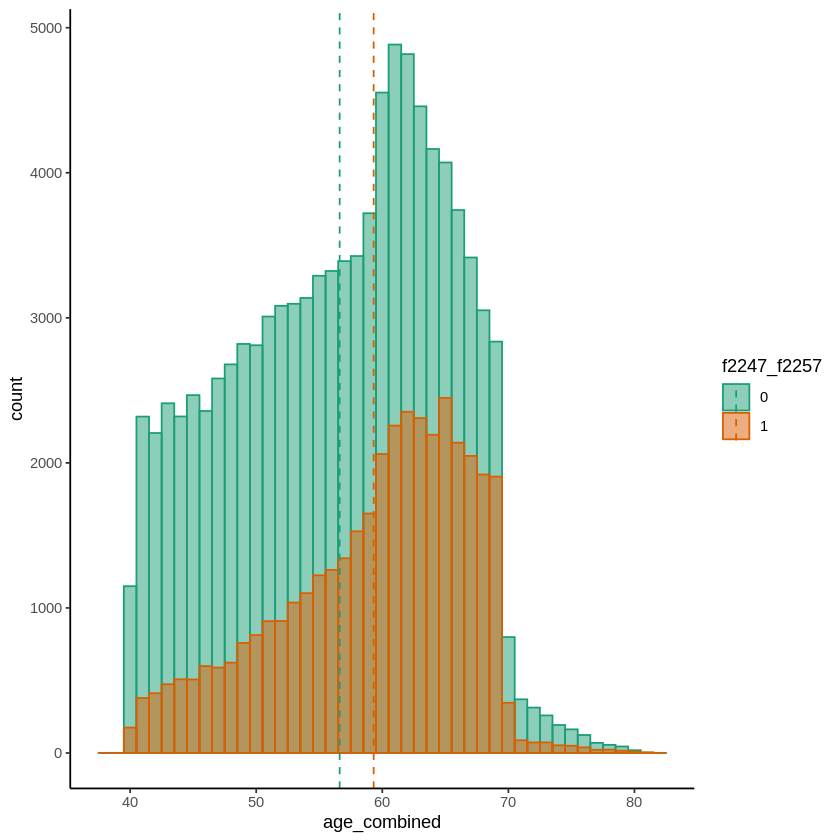

In [193]:
ggplot(f2247_f2257_pheno, aes(x=age_combined, fill=f2247_f2257, color=f2247_f2257)) +
 geom_histogram(binwidth=1, alpha=0.5, position="identity")+
  scale_color_brewer(palette="Dark2")+
  scale_fill_brewer(palette="Dark2") +
  theme(legend.position="top") +
  geom_vline(data=mu7, aes(xintercept=grp.mean, color=f2247_f2257),
             linetype="dashed") +
  theme_classic()

In [194]:
length(which((f2247_f2257_pheno$f2247_f2257=="0" & f2247_f2257_pheno$age_combined <50)))

[1] 23314

In [195]:
length(which((f2247_f2257_pheno$f2247_f2257=="1" & f2247_f2257_pheno$age_combined <50)))

[1] 5025

In [196]:
mu8 <- ddply(f2247_f2257_pheno, "sex", summarise, grp.mean=mean(age_combined))
head(mu8)

sex grp.mean
1 1   57.19543
2 0   57.63699

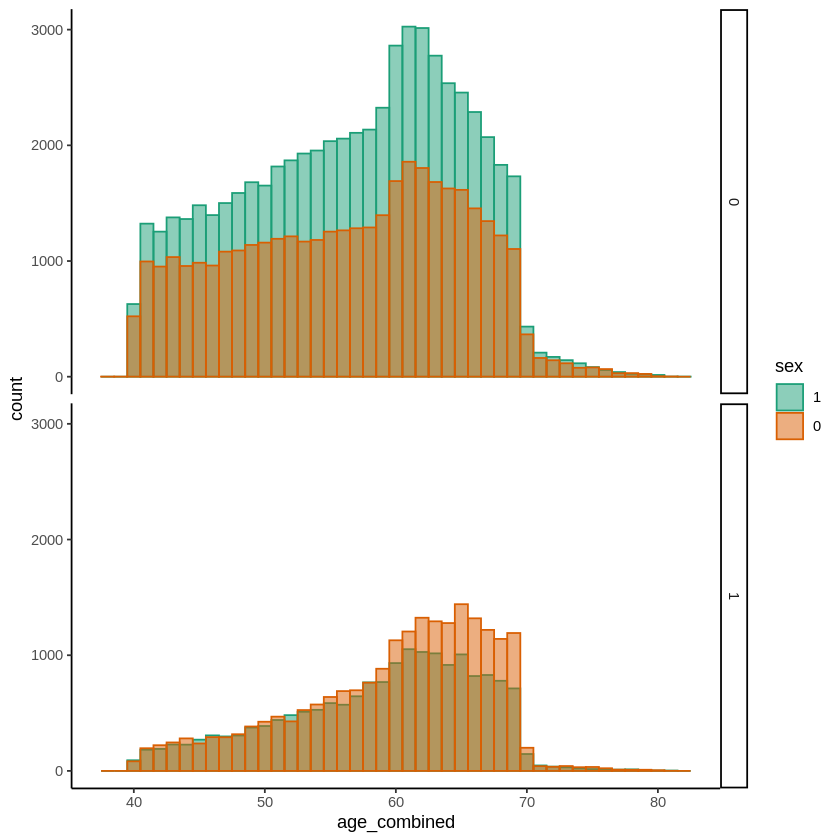

In [197]:
ggplot(f2247_f2257_pheno, aes(x=age_combined, fill=sex, color=sex)) +
 geom_histogram(binwidth=1, alpha=0.5, position="identity")+
  scale_color_brewer(palette="Dark2")+
  scale_fill_brewer(palette="Dark2") +
  theme(legend.position="top") +
  theme_classic() +
  facet_grid(f2247_f2257 ~ .)

In [198]:
#Summary age of cases and controls
tapply(f2247_f2257_pheno$age_combined,  f2247_f2257_pheno$f2247_f2257, summary)

$`0`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  38.00   50.00   58.00   56.62   63.00   82.00 

$`1`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  40.00   55.00   61.00   59.32   65.00   81.00 


## Find out controls positive for  f.3393

In [199]:
control_check_combined <- df_3393_2247_2257_combined %>%
    filter(f2247_f2257==0) %>%
    select(FID, IID, age_combined, sex, f2247_f2257, starts_with("f.3393")) %>%
    mutate(remove_3393 = apply(select(.,starts_with("f.3393")), 1, function(x) length(which(x == "Yes")) > 0))
head(control_check_combined)
dim(control_check_combined)

FID     IID     age_combined sex f2247_f2257 f.3393.0.0 f.3393.1.0 f.3393.2.0
1 1000078 1000078 60           1   0           NA         No         No        
2 1000081 1000081 67           0   0           No         NA         NA        
3 1000224 1000224 58           1   0           NA         NA         NA        
4 1000236 1000236 70           0   0           No         NA         No        
5 1000255 1000255 61           1   0           No         NA         No        
6 1000291 1000291 62           0   0           NA         NA         NA        
  f.3393.3.0 f.3393.0.0_recode f.3393.1.0_recode f.3393.2.0_recode
1 NA         NA                0                 0                
2 NA         0                 NA                NA               
3 NA         NA                NA                NA               
4 NA         0                 NA                0                
5 NA         0                 NA                0                
6 NA         NA                NA                NA               
  f.3393.3.0_recode remove_3393
1 NA                FALSE      
2 NA                FALSE      
3 NA                FALSE      
4 NA                FALSE      
5 NA                FALSE      
6 NA                FALSE

[1] 98012    14

In [200]:
length(which(control_check_combined$remove_3393==TRUE)) #controls that replied yes to f.3393

[1] 2

### Export file white-British

In [162]:
write.table(f2247_f2257_pheno, '200828_UKBB_f2247_f2257', quote = FALSE, row.names = FALSE)

### Export file white expanded

In [162]:
write.table(f2247_f2257_pheno, '120120_UKBB_f2247_f2257_expandedwhite', quote = FALSE, row.names = FALSE)

### Export exome data

In [171]:
write.table(f2247_f2257_pheno, 'phenotypes_exome_data/010421_UKBB_f2247_f2257_136862ind_exomes', quote = FALSE, row.names = FALSE)

## Controls negative for f.2247 & f.2257 & f.3393

In [201]:
pure_controls <- df_3393_2247_2257_combined %>%
    select(FID, IID, sex, hearing_aid_cat_new, age_final_aid, hearing_diff_new, age_final_diff_new, hearing_noise_cat, age_final_noise, f2247_f2257, age_combined) %>%
    mutate(control_pure= case_when((hearing_aid_cat_new=="0" & hearing_diff_new =="0" & hearing_noise_cat =="0") ~ "pure_control", TRUE ~ "other")) %>%
    mutate(control_na = case_when((hearing_diff_new =="0" & hearing_noise_cat =="0" & (is.na(hearing_aid_cat_new) | hearing_aid_cat_new=="0")) ~ "control_na", TRUE ~ "other")) %>%
    mutate(f3393_ctrl_pure = case_when((hearing_aid_cat_new=="1" & control_pure=="other") ~ "1",
                             (hearing_aid_cat_new=="0" & control_pure=="pure_control") ~ "0", TRUE ~ "NA")) %>%
    mutate(f3393_ctrl_na = case_when((hearing_aid_cat_new=="1" & control_na=="other") ~ "1",
                             (hearing_aid_cat_new %in% c("0", NA) & control_na=="control_na") ~ "0", TRUE ~ "NA")) %>%
    mutate(f2247_ctrl_pure = case_when((hearing_diff_new=="1" & control_pure=="other") ~ "1",
                             (hearing_diff_new=="0" & control_pure=="pure_control") ~ "0", TRUE ~ "NA")) %>%
    mutate(f2247_ctrl_na = case_when((hearing_diff_new=="1" & control_na=="other") ~ "1",
                             (hearing_diff_new == "0" & control_na=="control_na") ~ "0", TRUE ~ "NA")) %>% 
    mutate(f2257_ctrl_pure = case_when((hearing_noise_cat=="1" & control_pure=="other") ~ "1",
                             (hearing_noise_cat=="0" & control_pure=="pure_control") ~ "0", TRUE ~ "NA")) %>%
    mutate(f2257_ctrl_na = case_when((hearing_noise_cat=="1" & control_na=="other") ~ "1",
                             (hearing_noise_cat == "0" & control_na=="control_na") ~ "0", TRUE ~ "NA")) %>%
    mutate(f2247_f2257_ctrl_pure = case_when((f2247_f2257=="1" & control_pure=="other") ~ "1",
                             (f2247_f2257=="0" & control_pure=="pure_control") ~ "0", TRUE ~ "NA")) %>%
    mutate(f2247_f2257_ctrl_na = case_when((f2247_f2257=="1" & control_na=="other") ~ "1",
                             (f2247_f2257 == "0" & control_na=="control_na") ~ "0", TRUE ~ "NA"))

head(pure_controls, 100)
nrow(pure_controls)

FID     IID     sex hearing_aid_cat_new age_final_aid hearing_diff_new
1   1000019 1000019 1   0                   47            1               
2   1000035 1000035 0   0                   63            0               
3   1000078 1000078 1   0                   60            0               
4   1000081 1000081 0   0                   67            0               
5   1000198 1000198 1   0                   41            1               
6   1000210 1000210 0   NA                  NA            NA              
7   1000224 1000224 1   NA                  NA            0               
8   1000236 1000236 0   0                   70            0               
9   1000255 1000255 1   0                   61            0               
10  1000291 1000291 0   NA                  NA            0               
11  1000304 1000304 1   0                   56            0               
12  1000331 1000331 1   0                   53            0               
13  1000340 1000340 1   0                   54            0               
14  1000357 1000357 1   0                   69            0               
15  1000396 1000396 0   0                   48            1               
16  1000415 1000415 0   NA                  NA            0               
17  1000421 1000421 1   0                   64            0               
18  1000439 1000439 1   0                   59            0               
19  1000443 1000443 1   0                   52            0               
20  1000494 1000494 0   0                   61            1               
21  1000516 1000516 0   0                   46            0               
22  1000530 1000530 0   0                   67            0               
23  1000551 1000551 0   0                   68            NA              
24  1000609 1000609 1   0                   69            0               
25  1000611 1000611 1   0                   56            0               
26  1000625 1000625 1   0                   60            0               
27  1000642 1000642 1   0                   50            NA              
28  1000674 1000674 0   NA                  NA            0               
29  1000683 1000683 0   0                   68            0               
30  1000701 1000701 1   NA                  NA            0               
⋮   ⋮       ⋮       ⋮   ⋮                   ⋮             ⋮               
71  1001789 1001789 0   0                   45            NA              
72  1001811 1001811 1   0                   63            0               
73  1001825 1001825 1   NA                  NA            0               
74  1001842 1001842 1   NA                  NA            0               
75  1001856 1001856 0   NA                  NA            0               
76  1001860 1001860 1   0                   63            0               
77  1001883 1001883 1   0                   63            0               
78  1001897 1001897 0   0                   66            1               
79  1001905 1001905 0   0                   62            1               
80  1001953 1001953 1   0                   62            0               
81  1001970 1001970 1   0                   63            0               
82  1001998 1001998 0   0                   60            0               
83  1002018 1002018 0   0                   59            0               
84  1002023 1002023 0   0                   60            0               
85  1002040 1002040 1   0                   65            0               
86  1002085 1002085 1   0                   45            0               
87  1002096 1002096 0   0                   57            0               
88  1002152 1002152 1   NA                  NA            0               
89  1002180 1002180 1   NA                  NA            0               
90  1002199 1002199 1   0                   61            0               
91  1002230 1002230 0   0                   44            1               
92  1002251 1002251 1   0    

[1] 182761

In [202]:
df1 <- pure_controls %>% filter(is.na(age_final_aid)) %>% select('IID','hearing_aid_cat_new', "age_final_aid")

In [203]:
nrow(df1 %>% filter(is.na(hearing_aid_cat_new)))

[1] 54100

In [204]:
nrow(pure_controls %>% filter(hearing_aid_cat_new=='0'))

[1] 122271

In [205]:
nrow(pure_controls %>% filter(hearing_aid_cat_new=='1'))

[1] 6390

In [219]:
write.table(pure_controls, '043021_UKBB_f3393_f2247_f2257_combined_controls2sets', quote = FALSE, row.names = FALSE)

In [206]:
nrow(pure_controls %>% filter(control_pure == "pure_control"))

[1] 46717

## Age of pure controls

In [207]:
age_pure <- pure_controls %>% 
        filter(control_pure == "pure_control") %>%
        mutate(max_age=pmax(age_final_aid,age_final_diff_new,age_final_noise))
nrow(age_pure)

[1] 46717

In [208]:
diff_age_pure1 <- age_pure[age_pure$age_final_aid!=age_pure$age_final_diff_new, ]
nrow(diff_age_pure1)

[1] 5

In [209]:
diff_age_pure1

FID     IID     sex hearing_aid_cat_new age_final_aid hearing_diff_new
6872  1740024 1740024 0   0                   46            0               
24584 3659414 3659414 1   0                   73            0               
43391 5668953 5668953 1   0                   69            0               
44240 5762579 5762579 0   0                   78            0               
45289 5872104 5872104 1   0                   67            0               
      age_final_diff_new hearing_noise_cat age_final_noise f2247_f2257 ⋯
6872  41                 0                 46              0           ⋯
24584 64                 0                 64              0           ⋯
43391 74                 0                 69              0           ⋯
44240 68                 0                 68              0           ⋯
45289 61                 0                 61              0           ⋯
      control_na f3393_ctrl_pure f3393_ctrl_na f2247_ctrl_pure f2247_ctrl_na
6872  control_na 0               0             0               0            
24584 control_na 0               0             0               0            
43391 control_na 0               0             0               0            
44240 control_na 0               0             0               0            
45289 control_na 0               0             0               0            
      f2257_ctrl_pure f2257_ctrl_na f2247_f2257_ctrl_pure f2247_f2257_ctrl_na
6872  0               0             0                     0                  
24584 0               0             0                     0                  
43391 0               0             0                     0                  
44240 0               0             0                     0                  
45289 0               0             0                     0                  
      max_age
6872  46     
24584 73     
43391 74     
44240 78     
45289 67

In [210]:
diff_age_pure2 <- age_pure[age_pure$age_final_aid!=age_pure$age_final_noise, ]
nrow(diff_age_pure2)
diff_age_pure2

[1] 3

FID     IID     sex hearing_aid_cat_new age_final_aid hearing_diff_new
24584 3659414 3659414 1   0                   73            0               
44240 5762579 5762579 0   0                   78            0               
45289 5872104 5872104 1   0                   67            0               
      age_final_diff_new hearing_noise_cat age_final_noise f2247_f2257 ⋯
24584 64                 0                 64              0           ⋯
44240 68                 0                 68              0           ⋯
45289 61                 0                 61              0           ⋯
      control_na f3393_ctrl_pure f3393_ctrl_na f2247_ctrl_pure f2247_ctrl_na
24584 control_na 0               0             0               0            
44240 control_na 0               0             0               0            
45289 control_na 0               0             0               0            
      f2257_ctrl_pure f2257_ctrl_na f2247_f2257_ctrl_pure f2247_f2257_ctrl_na
24584 0               0             0                     0                  
44240 0               0             0                     0                  
45289 0               0             0                     0                  
      max_age
24584 73     
44240 78     
45289 67

In [211]:
diff_age_pure3 <- age_pure[age_pure$age_final_diff_new!=age_pure$age_final_noise, ]
nrow(diff_age_pure3)
diff_age_pure3

[1] 2

FID     IID     sex hearing_aid_cat_new age_final_aid hearing_diff_new
6872  1740024 1740024 0   0                   46            0               
43391 5668953 5668953 1   0                   69            0               
      age_final_diff_new hearing_noise_cat age_final_noise f2247_f2257 ⋯
6872  41                 0                 46              0           ⋯
43391 74                 0                 69              0           ⋯
      control_na f3393_ctrl_pure f3393_ctrl_na f2247_ctrl_pure f2247_ctrl_na
6872  control_na 0               0             0               0            
43391 control_na 0               0             0               0            
      f2257_ctrl_pure f2257_ctrl_na f2247_f2257_ctrl_pure f2247_f2257_ctrl_na
6872  0               0             0                     0                  
43391 0               0             0                     0                  
      max_age
6872  46     
43391 74

In [212]:
mean(age_pure[["max_age"]])

[1] 57.54509

## Age of controls_na

In [213]:
age_controls_na <- pure_controls %>% 
        filter(control_na == "control_na") %>%
        mutate(max_age_control_na=pmax(age_final_aid,age_final_diff_new,age_final_noise))
nrow(age_controls_na)

[1] 98012

In [214]:
mean(age_controls_na[["max_age_control_na"]])

[1] 57.54509

In [215]:
nrow(pure_controls %>% filter(control_na == "control_na"))

[1] 98012

In [216]:
#Number of cases of either f3393, f2257, or f2247

cases_either_trait<- df_3393_2247_2257_combined %>%
    select(FID, IID, sex, hearing_aid_cat_new, age_final_aid, hearing_diff_new, age_final_diff_new, hearing_noise_cat, age_final_noise, f2247_f2257, age_combined) %>%
    mutate(case_either_trait= case_when((hearing_aid_cat_new=="1" | hearing_diff_new =="1" | hearing_noise_cat =="1") ~ "case", TRUE ~ "control")) %>%
    filter(case_either_trait=="case")
nrow(cases_either_trait)

[1] 75905

In [217]:
head(cases_either_trait, 30)

FID     IID     sex hearing_aid_cat_new age_final_aid hearing_diff_new
1  1000019 1000019 1   0                   47            1               
2  1000035 1000035 0   0                   63            0               
3  1000198 1000198 1   0                   41            1               
4  1000304 1000304 1   0                   56            0               
5  1000396 1000396 0   0                   48            1               
6  1000494 1000494 0   0                   61            1               
7  1000551 1000551 0   0                   68            NA              
8  1000817 1000817 0   0                   58            0               
9  1000875 1000875 0   0                   59            NA              
10 1000988 1000988 1   0                   65            0               
11 1001076 1001076 0   0                   69            1               
12 1001080 1001080 1   0                   62            0               
13 1001123 1001123 1   0                   62            1               
14 1001140 1001140 1   0                   59            NA              
15 1001316 1001316 0   0                   51            1               
16 1001373 1001373 0   0                   67            1               
17 1001384 1001384 1   1                   61            1               
18 1001471 1001471 0   0                   61            0               
19 1001577 1001577 0   0                   61            1               
20 1001636 1001636 0   0                   64            1               
21 1001672 1001672 0   0                   66            0               
22 1001775 1001775 1   0                   61            1               
23 1001789 1001789 0   0                   45            NA              
24 1001811 1001811 1   0                   63            0               
25 1001897 1001897 0   0                   66            1               
26 1001905 1001905 0   0                   62            1               
27 1002023 1002023 0   0                   60            0               
28 1002040 1002040 1   0                   65            0               
29 1002230 1002230 0   0                   44            1               
30 1002251 1002251 1   0                   58            1               
   age_final_diff_new hearing_noise_cat age_final_noise f2247_f2257
1  47                 1                 47              1          
2  63                 1                 63              NA         
3  41                 1                 41              1          
4  56                 1                 56              NA         
5  48                 1                 48              1          
6  61                 1                 61              1          
7  NA                 1                 68              NA         
8  58                 1                 58              NA         
9  NA                 1                 59              NA         
10 65                 1                 65              NA         
11 69                 1                 69              1          
12 62                 1                 62              NA         
13 62                 1                 62              1          
14 NA                 1                 59              NA         
15 51                 0                 51              NA         
16 67                 1                 67              1          
17 61                 1                 61              1          
18 61                 1                 61              NA         
19 61                 1                 61              1          
20 64                 1                 64              1          
21 66                 1                 55              NA         
22 61                 1                 61              1          
23 NA                 1                 45              NA         
24 63                 1                 63              NA         
25 66    

## Total number of cases/controls for f.3393 using pure controls

In [218]:
nrow(pure_controls %>% filter(f3393_ctrl_pure == "1"))
nrow(pure_controls %>% filter(f3393_ctrl_pure == "0"))

[1] 6390

[1] 46717

In [219]:
nrow(pure_controls %>% filter(f3393_ctrl_na == "1"))
nrow(pure_controls %>% filter(f3393_ctrl_na == "0"))

[1] 6390

[1] 98012

## Total number of cases/controls for f.2247 using pure controls

In [220]:
nrow(pure_controls %>% filter(f2247_ctrl_pure == "1"))
nrow(pure_controls %>% filter(f2247_ctrl_pure == "0"))

[1] 46940

[1] 46717

In [221]:
nrow(pure_controls %>% filter(f2247_ctrl_na== "1"))
nrow(pure_controls %>% filter(f2247_ctrl_na == "0"))

[1] 46940

[1] 98012

## Total number of cases/controls for f.2257 using pure controls

In [222]:
nrow(pure_controls %>% filter(f2257_ctrl_pure == "1"))
nrow(pure_controls %>% filter(f2257_ctrl_pure == "0"))

[1] 68187

[1] 46717

In [223]:
nrow(pure_controls %>% filter(f2257_ctrl_na== "1"))
nrow(pure_controls %>% filter(f2257_ctrl_na == "0"))

[1] 68187

[1] 98012

## Total number of cases/controls for combined phenotype f2247 & f2257 using pure controls

In [250]:
nrow(pure_controls %>% filter(f2247_f2257_ctrl_pure == "1"))
nrow(pure_controls %>% filter(f2247_f2257_ctrl_pure == "0"))

[1] 39233

[1] 46717

In [251]:
nrow(pure_controls %>% filter(f2247_f2257_ctrl_na == "1"))
nrow(pure_controls %>% filter(f2247_f2257_ctrl_na == "0"))

[1] 39233

[1] 98012

## Creation of phenotype files with the 2 different sets of controls

In [224]:
f3393_ctrl_pure <- pure_controls %>%
    filter(!(f3393_ctrl_pure == "NA")) %>%
    select(FID,IID, sex,f3393_ctrl_pure, age_final_aid)
head(f3393_ctrl_pure)
nrow(f3393_ctrl_pure)

FID     IID     sex f3393_ctrl_pure age_final_aid
1 1000078 1000078 1   0               60           
2 1000081 1000081 0   0               67           
3 1000236 1000236 0   0               70           
4 1000255 1000255 1   0               61           
5 1000331 1000331 1   0               53           
6 1000340 1000340 1   0               54

[1] 53107

In [225]:
length(which(is.na(f3393_ctrl_pure$age_final_aid)))

[1] 0

In [392]:
write.table(f3393_ctrl_pure, '041521_UKBB_Hearing_aid_f3393_expandedwhite_z974included_pure_ctrl_97258ind', quote = FALSE, row.names = FALSE)

## File for exome data

In [226]:
write.table(f3393_ctrl_pure, '062421_UKBB_Hearing_aid_f3393_expandedwhite_z974included_pure_ctrl_53107ind', quote = FALSE, row.names = FALSE)

In [227]:
f3393_ctrl_na <- pure_controls %>%
    filter(!(f3393_ctrl_na == "NA")) %>%
    select(FID,IID, sex, f3393_ctrl_na, age_final_aid)
head(f3393_ctrl_na)
nrow(f3393_ctrl_na)

FID     IID     sex f3393_ctrl_na age_final_aid
1 1000078 1000078 1   0             60           
2 1000081 1000081 0   0             67           
3 1000224 1000224 1   0             NA           
4 1000236 1000236 0   0             70           
5 1000255 1000255 1   0             61           
6 1000291 1000291 0   0             NA

[1] 104402

In [228]:
# Create a dataset that has the controls_na with the correct age
f3393_ctrl_na_1 <- pure_controls %>%
    filter(!(f3393_ctrl_na == "NA")) %>%
    filter(is.na(hearing_aid_cat_new)) %>%
    mutate(age_aid =pmax(age_final_diff_new,age_final_noise)) %>%
    select(FID,IID, sex, f3393_ctrl_na, age_aid)
head(f3393_ctrl_na_1, 100)
nrow(f3393_ctrl_na_1)

FID     IID     sex f3393_ctrl_na age_aid
1   1000224 1000224 1   0             58     
2   1000291 1000291 0   0             62     
3   1000415 1000415 0   0             65     
4   1000674 1000674 0   0             41     
5   1000701 1000701 1   0             58     
6   1000752 1000752 1   0             53     
7   1000858 1000858 0   0             61     
8   1000889 1000889 1   0             55     
9   1001118 1001118 1   0             58     
10  1001281 1001281 1   0             54     
11  1001327 1001327 0   0             68     
12  1001414 1001414 1   0             49     
13  1001420 1001420 1   0             45     
14  1001669 1001669 1   0             62     
15  1001726 1001726 1   0             47     
16  1001825 1001825 1   0             46     
17  1001842 1001842 1   0             52     
18  1001856 1001856 0   0             56     
19  1002152 1002152 1   0             69     
20  1002180 1002180 1   0             59     
21  1002284 1002284 0   0             57     
22  1002346 1002346 1   0             49     
23  1002442 1002442 1   0             48     
24  1002591 1002591 1   0             57     
25  1002639 1002639 1   0             61     
26  1002677 1002677 1   0             54     
27  1002682 1002682 1   0             68     
28  1002729 1002729 1   0             40     
29  1002798 1002798 0   0             64     
30  1002820 1002820 1   0             54     
⋮   ⋮       ⋮       ⋮   ⋮             ⋮      
71  1007709 1007709 1   0             69     
72  1007803 1007803 1   0             64     
73  1007918 1007918 0   0             55     
74  1007923 1007923 1   0             42     
75  1008068 1008068 0   0             54     
76  1008301 1008301 0   0             53     
77  1008507 1008507 0   0             59     
78  1008546 1008546 0   0             53     
79  1009072 1009072 0   0             69     
80  1009114 1009114 1   0             67     
81  1009120 1009120 1   0             44     
82  1009297 1009297 1   0             54     
83  1009386 1009386 1   0             65     
84  1009540 1009540 1   0             59     
85  1009746 1009746 1   0             47     
86  1009754 1009754 0   0             55     
87  1009778 1009778 1   0             68     
88  1009781 1009781 1   0             41     
89  1009834 1009834 0   0             62     
90  1010026 1010026 1   0             55     
91  1010061 1010061 0   0             41     
92  1010130 1010130 1   0             45     
93  1010299 1010299 0   0             51     
94  1010486 1010486 0   0             43     
95  1010498 1010498 1   0             49     
96  1010520 1010520 1   0             65     
97  1010607 1010607 1   0             58     
98  1010635 1010635 1   0             60     
99  1010711 1010711 0   0             55     
100 1010848 1010848 1   0             64

[1] 51295

In [229]:
f3393_ctrl_na_2  <- pure_controls %>%
    filter(!(f3393_ctrl_na == "NA")) %>%
    filter(!is.na(hearing_aid_cat_new)) %>%
    mutate(age_aid = age_final_aid) %>%
    select(FID,IID, sex, f3393_ctrl_na, age_aid)
head(f3393_ctrl_na_2, 100)
nrow(f3393_ctrl_na_2)

FID     IID     sex f3393_ctrl_na age_aid
1   1000078 1000078 1   0             60     
2   1000081 1000081 0   0             67     
3   1000236 1000236 0   0             70     
4   1000255 1000255 1   0             61     
5   1000331 1000331 1   0             53     
6   1000340 1000340 1   0             54     
7   1000357 1000357 1   0             69     
8   1000421 1000421 1   0             64     
9   1000439 1000439 1   0             59     
10  1000516 1000516 0   0             46     
11  1000530 1000530 0   0             67     
12  1000609 1000609 1   0             69     
13  1000611 1000611 1   0             56     
14  1000683 1000683 0   0             68     
15  1000893 1000893 1   0             65     
16  1000992 1000992 0   0             56     
17  1001179 1001179 1   0             66     
18  1001207 1001207 1   0             65     
19  1001349 1001349 1   0             61     
20  1001351 1001351 1   0             54     
21  1001384 1001384 1   1             61     
22  1001395 1001395 1   0             64     
23  1001691 1001691 0   0             77     
24  1001717 1001717 0   0             60     
25  1001860 1001860 1   0             63     
26  1001883 1001883 1   0             63     
27  1001953 1001953 1   0             62     
28  1001970 1001970 1   0             63     
29  1001998 1001998 0   0             60     
30  1002018 1002018 0   0             59     
⋮   ⋮       ⋮       ⋮   ⋮             ⋮      
71  1005480 1005480 1   0             68     
72  1005604 1005604 0   0             60     
73  1005618 1005618 1   0             46     
74  1005743 1005743 1   0             63     
75  1005895 1005895 1   0             68     
76  1006021 1006021 0   0             41     
77  1006375 1006375 1   0             48     
78  1006454 1006454 1   1             64     
79  1006501 1006501 1   0             63     
80  1006513 1006513 1   1             59     
81  1006552 1006552 0   0             56     
82  1006576 1006576 1   0             49     
83  1006698 1006698 1   0             61     
84  1006730 1006730 1   0             64     
85  1006784 1006784 1   0             65     
86  1006831 1006831 0   0             51     
87  1006991 1006991 1   0             59     
88  1007000 1007000 0   0             58     
89  1007061 1007061 0   0             65     
90  1007116 1007116 0   0             50     
91  1007308 1007308 1   0             66     
92  1007678 1007678 1   0             60     
93  1007725 1007725 1   1             69     
94  1007810 1007810 1   0             67     
95  1008002 1008002 1   0             46     
96  1008144 1008144 1   0             61     
97  1008215 1008215 0   0             69     
98  1008221 1008221 1   0             61     
99  1008313 1008313 1   0             51     
100 1008376 1008376 0   0             45

[1] 53107

In [230]:
#Merge the 2 datasets fro f3393 with ages fixed
f3393_ctrl_na <- rbind(f3393_ctrl_na_1,f3393_ctrl_na_2) 
nrow(f3393_ctrl_na)

[1] 104402

In [231]:
length(which(is.na(f3393_ctrl_na$age_aid)))

[1] 0

In [293]:
write.table(f3393_ctrl_na, '041521_UKBB_Hearing_aid_f3393_expandedwhite_z974included_ctrl_na_228760ind', quote = FALSE, row.names = FALSE)

## File for exome data

In [232]:
write.table(f3393_ctrl_na, '062421_UKBB_Hearing_aid_f3393_expandedwhite_z974included_ctrl_na_104402ind', quote = FALSE, row.names = FALSE)

In [233]:
f2247_ctrl_pure <- pure_controls %>%
    filter(!(f2247_ctrl_pure == "NA")) %>%
    select(FID,IID, sex,f2247_ctrl_pure, age_final_diff_new)
head(f2247_ctrl_pure)
nrow(f2247_ctrl_pure)

FID     IID     sex f2247_ctrl_pure age_final_diff_new
1 1000019 1000019 1   1               47                
2 1000078 1000078 1   0               60                
3 1000081 1000081 0   0               67                
4 1000198 1000198 1   1               41                
5 1000236 1000236 0   0               70                
6 1000255 1000255 1   0               61

[1] 93657

In [394]:
write.table(f2247_ctrl_pure , '041521_UKBB_Hearing_difficulty_f2247_expandedwhite_z974included_pure_ctrl_184909ind', quote = FALSE, row.names = FALSE)

## File for exome data

In [235]:
write.table(f2247_ctrl_pure , '062421_UKBB_Hearing_difficulty_f2247_expandedwhite_z974included_pure_ctrl_93657ind', quote = FALSE, row.names = FALSE)

In [236]:
f2247_ctrl_na <- pure_controls %>%
    filter(!(f2247_ctrl_na == "NA")) %>%
    select(FID,IID, sex,f2247_ctrl_na, age_final_diff_new)
head(f2247_ctrl_na)
nrow(f2247_ctrl_na)

FID     IID     sex f2247_ctrl_na age_final_diff_new
1 1000019 1000019 1   1             47                
2 1000078 1000078 1   0             60                
3 1000081 1000081 0   0             67                
4 1000198 1000198 1   1             41                
5 1000224 1000224 1   0             58                
6 1000236 1000236 0   0             70

[1] 144952

In [395]:
write.table(f2247_ctrl_na , '041521_UKBB_Hearing_difficulty_f2247_expandedwhite_z974included_ctrl_na_316411ind', quote = FALSE, row.names = FALSE)

## File for exome data

In [237]:
write.table(f2247_ctrl_na , '062421_UKBB_Hearing_difficulty_f2247_expandedwhite_z974included_ctrl_na_144952ind', quote = FALSE, row.names = FALSE)

In [238]:
f2257_ctrl_pure <- pure_controls %>%
    filter(!(f2257_ctrl_pure == "NA")) %>%
    select(FID,IID, sex,f2257_ctrl_pure, age_final_noise)
head(f2257_ctrl_pure)
nrow(f2257_ctrl_pure)

FID     IID     sex f2257_ctrl_pure age_final_noise
1 1000019 1000019 1   1               47             
2 1000035 1000035 0   1               63             
3 1000078 1000078 1   0               60             
4 1000081 1000081 0   0               67             
5 1000198 1000198 1   1               41             
6 1000236 1000236 0   0               70

[1] 114904

In [396]:
write.table(f2257_ctrl_pure, '041521_UKBB_Hearing_background_noise_f2257_expandedwhite_z974included_pure_ctrl_232101ind', quote = FALSE, row.names = FALSE)

## File for exome data

In [239]:
write.table(f2257_ctrl_pure, '062421_UKBB_Hearing_background_noise_f2257_expandedwhite_z974included_pure_ctrl_114904ind', quote = FALSE, row.names = FALSE)

In [240]:
f2257_ctrl_na <- pure_controls %>%
    filter(!(f2257_ctrl_na == "NA")) %>%
    select(FID,IID, sex,f2257_ctrl_na, age_final_noise)
head(f2257_ctrl_na)
nrow(f2257_ctrl_na)

FID     IID     sex f2257_ctrl_na age_final_noise
1 1000019 1000019 1   1             47             
2 1000035 1000035 0   1             63             
3 1000078 1000078 1   0             60             
4 1000081 1000081 0   0             67             
5 1000198 1000198 1   1             41             
6 1000224 1000224 1   0             58

[1] 166199

In [397]:
write.table(f2257_ctrl_na, '041521_UKBB_Hearing_background_noise_f2257_expandedwhite_z974included_ctrl_na_363603ind', quote = FALSE, row.names = FALSE)

## File for exome data

In [241]:
write.table(f2257_ctrl_na, '062421_UKBB_Hearing_background_noise_f2257_expandedwhite_z974included_ctrl_na_166199ind', quote = FALSE, row.names = FALSE)

In [242]:
f2247_f2257_ctrl_pure  <- pure_controls %>%
    filter(!(f2247_f2257_ctrl_pure == "NA")) %>%
    select(FID,IID, sex,f2247_f2257_ctrl_pure, age_combined)
head(f2247_f2257_ctrl_pure)
nrow(f2247_f2257_ctrl_pure)

FID     IID     sex f2247_f2257_ctrl_pure age_combined
1 1000019 1000019 1   1                     47          
2 1000078 1000078 1   0                     60          
3 1000081 1000081 0   0                     67          
4 1000198 1000198 1   1                     41          
5 1000236 1000236 0   0                     70          
6 1000255 1000255 1   0                     61

[1] 85950

In [398]:
write.table(f2247_f2257_ctrl_pure, '041521_UKBB_f2247_f2257_expandedwhite_z974included_pure_ctrl_168414ind', quote = FALSE, row.names = FALSE)

## File for exome data

In [243]:
write.table(f2247_f2257_ctrl_pure, '062421_UKBB_f2247_f2257_expandedwhite_z974included_pure_ctrl_85950ind', quote = FALSE, row.names = FALSE)

In [244]:
f2247_f2257_ctrl_na  <- pure_controls %>%
    filter(!(f2247_f2257_ctrl_na == "NA")) %>%
    select(FID,IID, sex,f2247_f2257_ctrl_na, age_combined)
head(f2247_f2257_ctrl_na)
nrow(f2247_f2257_ctrl_na)

FID     IID     sex f2247_f2257_ctrl_na age_combined
1 1000019 1000019 1   1                   47          
2 1000078 1000078 1   0                   60          
3 1000081 1000081 0   0                   67          
4 1000198 1000198 1   1                   41          
5 1000224 1000224 1   0                   58          
6 1000236 1000236 0   0                   70

[1] 137245

In [399]:
write.table(f2247_f2257_ctrl_na, '041521_UKBB_f2247_f2257_expandedwhite_z974included_ctrl_na_299916ind', quote = FALSE, row.names = FALSE)

## File for exome data

In [245]:
write.table(f2247_f2257_ctrl_na, '062421_UKBB_f2247_f2257_expandedwhite_z974included_ctrl_na_137245ind', quote = FALSE, row.names = FALSE)

In [246]:
pure_controls_na <- df_3393_2247_2257_combined %>%
    select(FID, IID, sex, hearing_aid_cat_new, age_final_aid, hearing_diff_new, age_final_diff_new, hearing_noise_cat, age_final_noise, f2247_f2257, age_combined) %>%
    filter(hearing_diff_new =="0" & hearing_noise_cat =="0" & (is.na(hearing_aid_cat_new) | hearing_aid_cat_new=="0") )
head(pure_controls_na)
nrow(pure_controls_na)

FID     IID     sex hearing_aid_cat_new age_final_aid hearing_diff_new
1 1000078 1000078 1   0                   60            0               
2 1000081 1000081 0   0                   67            0               
3 1000224 1000224 1   NA                  NA            0               
4 1000236 1000236 0   0                   70            0               
5 1000255 1000255 1   0                   61            0               
6 1000291 1000291 0   NA                  NA            0               
  age_final_diff_new hearing_noise_cat age_final_noise f2247_f2257 age_combined
1 60                 0                 60              0           60          
2 67                 0                 67              0           67          
3 58                 0                 58              0           58          
4 70                 0                 70              0           70          
5 61                 0                 61              0           61          
6 62                 0                 62              0           62

[1] 98012

In [247]:
hearing_aid_inconsistent <- df_3393_2247_2257_combined %>%
    select(FID, IID, sex, hearing_aid_cat_new, age_final_aid, hearing_diff_new,hearing_diff_cat, age_final_diff_new, hearing_noise_cat, age_final_noise, f2247_f2257, age_combined) %>%
    filter(hearing_aid_cat_new==1 & (hearing_diff_new ==0 | hearing_noise_cat ==0))
head(hearing_aid_inconsistent)
nrow(hearing_aid_inconsistent)

FID     IID     sex hearing_aid_cat_new age_final_aid hearing_diff_new
1 1011769 1011769 1   1                   68            1               
2 1078188 1078188 0   1                   68            1               
3 1131323 1131323 1   1                   59            1               
4 1131551 1131551 0   1                   61            1               
5 1133195 1133195 1   1                   67            1               
6 1137492 1137492 1   1                   69            1               
  hearing_diff_cat age_final_diff_new hearing_noise_cat age_final_noise
1 1                68                 0                 68             
2 1                68                 0                 68             
3 1                59                 0                 59             
4 1                61                 0                 61             
5 1                67                 0                 67             
6 1                69                 0                 69             
  f2247_f2257 age_combined
1 NA          NA          
2 NA          NA          
3 NA          NA          
4 NA          NA          
5 NA          NA          
6 NA          NA

[1] 249

In [248]:
hearing_aid_inconsistent <- df_3393_2247_2257_combined %>%
    select(FID, IID, sex, hearing_aid_cat_new, age_final_aid, hearing_diff_new,hearing_diff_cat, age_final_diff_new, hearing_noise_cat, age_final_noise, f2247_f2257, age_combined) %>%
    filter(hearing_aid_cat_new==1 & hearing_noise_cat ==0)
head(hearing_aid_inconsistent)
nrow(hearing_aid_inconsistent)

FID     IID     sex hearing_aid_cat_new age_final_aid hearing_diff_new
1 1011769 1011769 1   1                   68            1               
2 1078188 1078188 0   1                   68            1               
3 1131323 1131323 1   1                   59            1               
4 1131551 1131551 0   1                   61            1               
5 1133195 1133195 1   1                   67            1               
6 1137492 1137492 1   1                   69            1               
  hearing_diff_cat age_final_diff_new hearing_noise_cat age_final_noise
1 1                68                 0                 68             
2 1                68                 0                 68             
3 1                59                 0                 59             
4 1                61                 0                 61             
5 1                67                 0                 67             
6 1                69                 0                 69             
  f2247_f2257 age_combined
1 NA          NA          
2 NA          NA          
3 NA          NA          
4 NA          NA          
5 NA          NA          
6 NA          NA

[1] 249

In [390]:
head(df_3393_2247_2257_combined)

IID     FID     ignore1 ignore2 ignore3 ignore4 f.31.0.0 f.34.0.0 f.53.0.0  
1 1000019 1000019 0       0       2       -9      Female   1960     2008-01-24
2 1000022 1000022 0       0       1       -9      Male     1954     2008-01-22
3 1000035 1000035 0       0       1       -9      Male     1944     2007-11-08
4 1000046 1000046 0       0       2       -9      Female   1946     2008-12-01
5 1000054 1000054 0       0       2       -9      Female   1942     2007-11-23
6 1000063 1000063 0       0       1       -9      Male     1967     2010-06-26
  f.53.1.0 ⋯ age_final_aid hearing_diff_cat age_final_diff hearing_diff_cat_new
1 NA       ⋯ 47            1                47             case                
2 NA       ⋯ 53            1                53             case                
3 NA       ⋯ 63            0                63             control             
4 NA       ⋯ 73            0                73             control             
5 NA       ⋯ 65            0                65             control             
6 NA       ⋯ 43            0                43             control             
  hearing_aid_cat_new hearing_diff_new hearing_noise_cat age_final_noise
1 control             1                1                 47             
2 control             1                1                 53             
3 control             0                1                 63             
4 control             0                1                 73             
5 control             0                1                 65             
6 control             0                0                 43             
  f2247_f2257 age_combined
1 1           47          
2 1           53          
3 NA          NA          
4 NA          NA          
5 NA          NA          
6 0           43

In [ ]:
hearing_aid_z974 <- df_3393_2247_2257_combined %>%
    select(FID, IID, sex, hearing_aid_cat, age_final_aid, hearing_diff_new, age_final_diff, hearing_noise_cat, age_final_noise, f2247_f2257, age_combined) %>%
    filter(IID %in% ICD10_z974$IID) %>%
    filter(is.na(hearing_aid_cat))
head(hearing_aid_z974)
nrow(hearing_aid_z974)